### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Friday, Mar 27th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

**1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.**

**2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:**

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

**where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.**

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

**3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.**

**4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).**

**5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.**

**6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.**

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [179]:
# IMPORTS
##########
##########

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import corner
import random as r
%matplotlib inline

from scipy.stats import norm
from scipy.stats import uniform

## Part 1

In [35]:
#CLD reading in the data 
placeholder = np.load('../../../coursework/homeworks/hw_data/hw5_data_1.npy')
time = placeholder[:,0]
flux = placeholder[:,1]
error = placeholder[:,2]

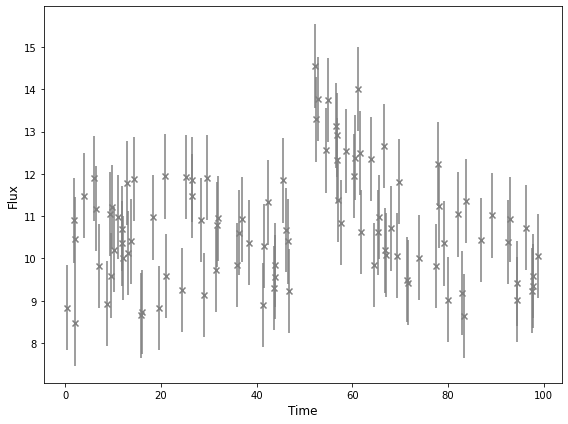

In [15]:
#CLD plotting this data with the respective error bars, flux v time
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(time, flux, c='grey', marker='x')
ax.errorbar(time, flux, yerr=error, c='grey', fmt='none')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Flux', fontsize=12)
fig.tight_layout()
plt.show(fig);

## Part 2

In [85]:
#CLD writing the code for this burst model
#CLD coeff should be in format [b, A, alpha, t0]
def burst_model(coeff, x):
    y_fit = []
    for i in range(len(x)):
        if x[i]<coeff[3]:
            y_fit.append(coeff[0])
        if x[i]>=coeff[3]:
            y_fit.append(coeff[0] + coeff[1]*np.exp(-coeff[2]*(x[i] - coeff[3])))
    return np.asarray(y_fit)

def burst_likelihood(coeff, t, f, e):
    fit = burst_model(coeff, t) #CLD fitting using the burst model
    L = np.prod(norm.pdf(f, fit, e))#CLD the likelihood with priors of the burst model
    return L

SRT: burst_model could be faster if code were more "pythonic". Instead of a for-loop over the observations, you can create a mask that would allow you to pass in and operate on an array of times.  -2

e.g.

y = np.empty(t.shape)

y.fill(b0)

mask = (t >= t0)

y[mask] += A * np.exp(-alpha * (t[mask] - t0))

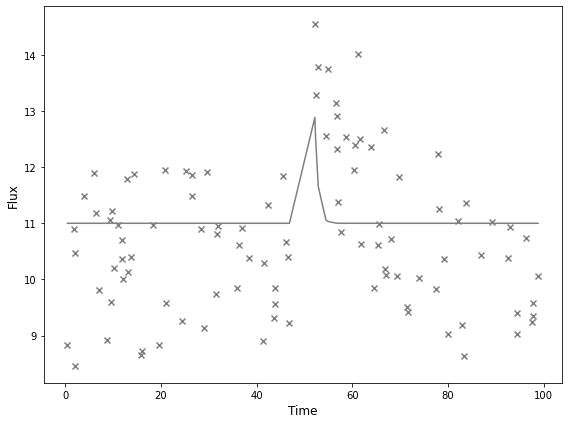

In [73]:
#CLD checking burst model code real quick
y = burst_model([11,50,1.5,50], time)
#CLD plotting this data with the respective error bars, flux v time
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(time, flux, c='grey', marker='x')
ax.plot(time, y, c='grey')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Flux', fontsize=12)
fig.tight_layout()
plt.show(fig);

#CLD i mean it looks bad but it is working

## Part 3

In [100]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have mpi4py package.


In [104]:
#CLD coding in the priors 
def priors(coeff):
    p1 = uniform.pdf(coeff[0], 0, 50) #CLD prior on b
    p2 = uniform.pdf(coeff[1], 0, 50) #CLD prior on A
    
    lna = np.log(coeff[2]) #CLD need lna for prior
    p3 = uniform.pdf(lna, -5, (5+5)) #CLD prior on lna
    p4 = uniform.pdf(coeff[3], 0, 100) #CLD prior on t0
    
    return p1*p2*p3*p4

def log_prior(coeff):
    return np.log(priors(coeff))

def logL(coeff):
    return np.log(burst_likelihood(coeff, time, flux, error))

In [263]:
ndim = 4 #CLD number of parameters I'm fitting

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, log_prior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

# sampler for N steps
N = int(15e4)
x0 = np.random.random((ndim,))+10
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.67 percent in 0.873322 s Acceptance rate = 0.979

<ipython-input-104-caac95dc2153>:16: RuntimeWarning: divide by zero encountered in log
  return np.log(burst_likelihood(coeff, time, flux, error))


Finished 1.33 percent in 1.766337 s Acceptance rate = 0.808

<ipython-input-104-caac95dc2153>:6: RuntimeWarning: invalid value encountered in log
  lna = np.log(coeff[2]) #CLD need lna for prior
/Users/carriedrake/opt/anaconda3/envs/astr8070/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
<ipython-input-104-caac95dc2153>:13: RuntimeWarning: divide by zero encountered in log
  return np.log(priors(coeff))


Finished 2.00 percent in 2.645321 s Acceptance rate = 0.751

<ipython-input-85-5ab630f015c8>:9: RuntimeWarning: overflow encountered in exp
  y_fit.append(coeff[0] + coeff[1]*np.exp(-coeff[2]*(x[i] - coeff[3])))


Finished 2.67 percent in 3.437749 s Acceptance rate = 0.601

<ipython-input-85-5ab630f015c8>:9: RuntimeWarning: overflow encountered in double_scalars
  y_fit.append(coeff[0] + coeff[1]*np.exp(-coeff[2]*(x[i] - coeff[3])))


Finished 6.67 percent in 8.096900 s Acceptance rate = 0.291444Adding DE jump with weight 50
Finished 99.33 percent in 126.870696 s Acceptance rate = 0.225094
Run Complete


## Part 4

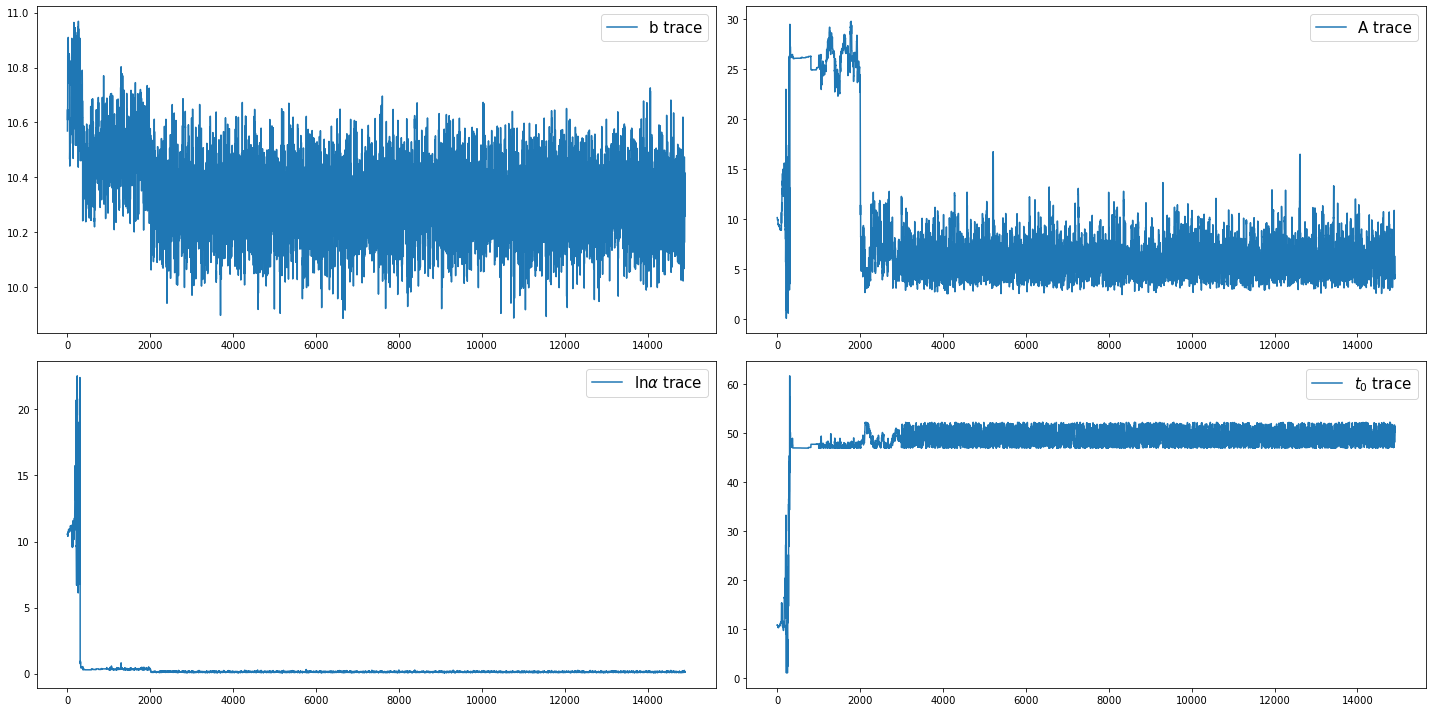

In [264]:
#CLD plotting the trace to check for where a good place to start burn in would be
#CLD loading in the traces from the ptmcmc
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

bs = chain[:,0]
As = chain[:,1]
alphas = chain[:,2]
ts = chain[:,3]
M = len(bs)

grid = np.linspace(0,M,M)

fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(grid, bs, label='b trace')
ax[0,1].plot(grid, As, label='A trace')
ax[1,0].plot(grid, alphas, label=r'ln$\alpha$ trace')
ax[1,1].plot(grid, ts, label=r'$t_0$ trace')
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[1,0].legend(fontsize=15)
ax[1,1].legend(fontsize=15)
fig.tight_layout()
plt.show(fig);

To me, it looks like a good burn in place would be at about 4000 for each of the graphs.

In [265]:
#CLD burning in the chains with my burn in value
burn = 4000

#CLD to calculate the autocorrelation length use the same diagnostic method presented in lecture 11
import acor
b_auto = acor.acor(chain[burn:,0]) 
a_auto = acor.acor(chain[burn:,1])
alpha_auto = acor.acor(chain[burn:,2])
t_auto = acor.acor(chain[burn:,3])

#CLD the autocorrelation length is the nearest int to the first element in the tuple
print(int(b_auto[0]))
print(int(a_auto[0]))
print(int(alpha_auto[0])) #CLD this is the longest autocorrelation length so will be using this one
print(int(t_auto[0]))

3
5
5
5


In [266]:
#CLD burning in the chains
b_burn = bs[burn:]
a_burn = As[burn:]
alpha_burn = alphas[burn:]
t_burn = ts[burn:]

#CLD making autocorrelation thinning indices arrays
b_ind = np.arange(0, len(b_burn), int(alpha_auto[0]))
a_ind = np.arange(0, len(a_burn), int(alpha_auto[0]))
alpha_ind = np.arange(0, len(alpha_burn), int(alpha_auto[0]))
t_ind = np.arange(0, len(t_burn), int(alpha_auto[0]))

#CLD masking the burned in trace array to the thined indices of these arrays
b_burn_thin = b_burn[b_ind]
a_burn_thin = a_burn[a_ind]
alpha_burn_thin = alpha_burn[alpha_ind]
t_burn_thin = t_burn[t_ind]

2180
2180
2180
2180


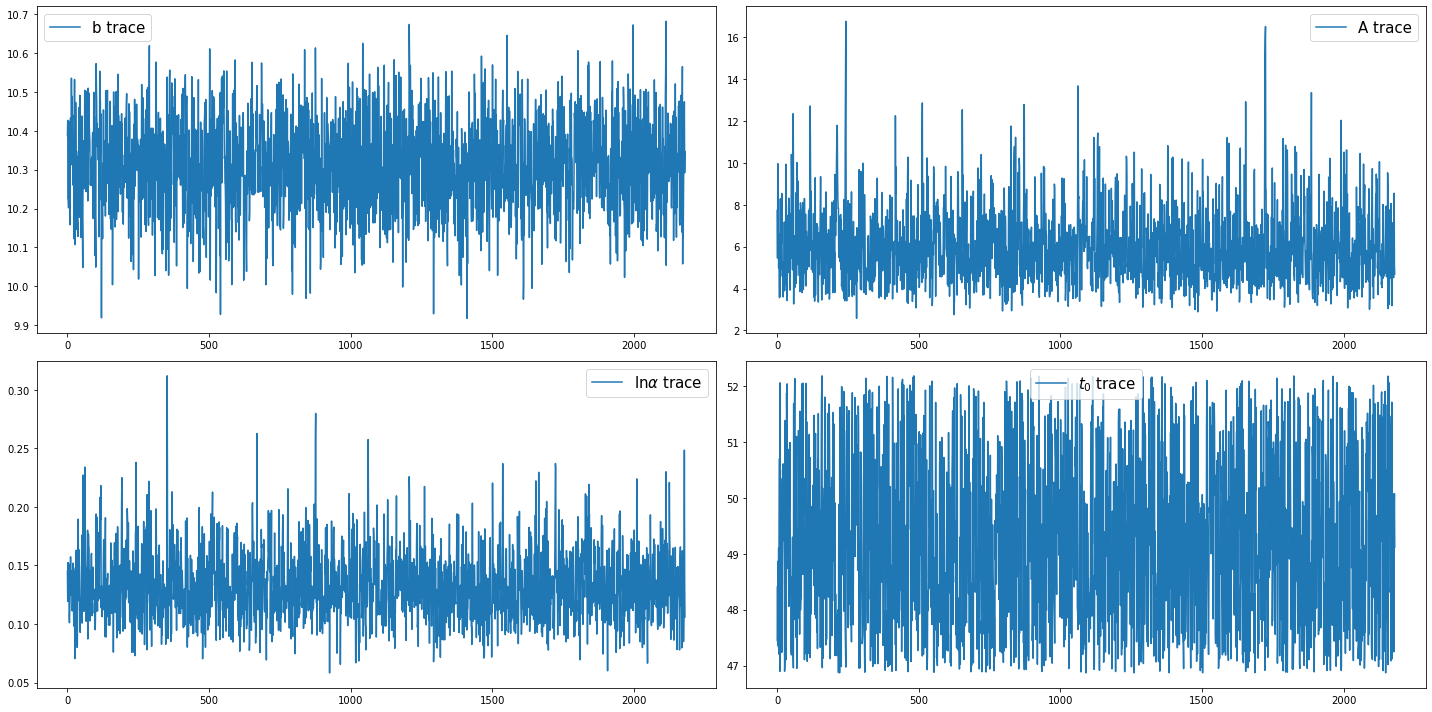

In [267]:
#CLD checking to make sure I don't need more samples by replotting traces and seeing size of the arrays
#CLD begin by making new x grid for each set of samples as they were thinned by a different amount
bgrid = np.linspace(0, len(b_burn_thin),len(b_burn_thin))
agrid = np.linspace(0, len(a_burn_thin),len(a_burn_thin))
alphagrid = np.linspace(0, len(alpha_burn_thin),len(alpha_burn_thin))
tgrid = np.linspace(0, len(t_burn_thin),len(t_burn_thin))

#CLD the grid lengths should be good reps of new size of each chain
print(len(bgrid))
print(len(agrid))
print(len(alphagrid))
print(len(tgrid))

#CLD plotting the thinned and burned trace plots
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(bgrid, b_burn_thin, label='b trace')
ax[0,1].plot(agrid, a_burn_thin, label='A trace')
ax[1,0].plot(alphagrid, alpha_burn_thin, label=r'ln$\alpha$ trace')
ax[1,1].plot(tgrid, t_burn_thin, label=r'$t_0$ trace')
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[1,0].legend(fontsize=15)
ax[1,1].legend(fontsize=15)
fig.tight_layout()
plt.show(fig);

## Part 5

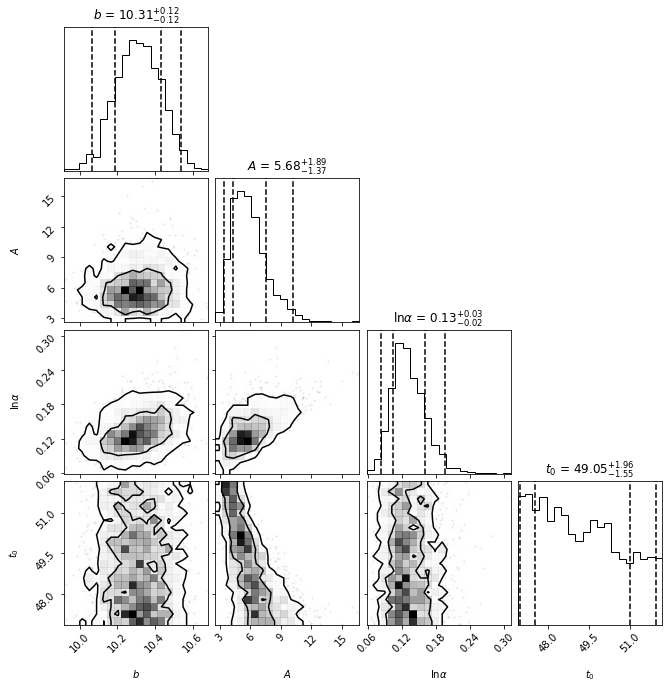

In [268]:
#CLD making a corner plot in 4d parameter space
ndim, nsamples = 1, len(bgrid)

data = np.hstack([b_burn_thin.reshape([nsamples,ndim]), a_burn_thin.reshape([nsamples,ndim]), 
                  alpha_burn_thin.reshape([nsamples,ndim]), t_burn_thin.reshape([nsamples,ndim])])

#CLD 
figure = corner.corner(data, labels=[r"$b$", r"$A$", r"$\ln \alpha$", r"$t_0$"], levels=[0.68, 0.95],
                       quantiles=[0.025, 0.16, 0.84, .975], show_titles=True, title_kwargs={"fontsize": 12})

SRT: Correct priors, but you did not actually sample in log-alpha, so there is a mislabeling. This is alpha. -1

## Problem 6

In [269]:
#CLD drawing the 100 random samples for each coeff
bees = r.choices(b_burn_thin, k=100)
aees = r.choices(a_burn_thin, k=100)
alphaees = r.choices(alpha_burn_thin, k=100)
tees = r.choices(t_burn_thin, k=100)

SRT: Almost, but you are selecting different points in the chain for each parameter. This means you are losing the covariance between parameters that exists in the posterior. The correct way is to draw 100 random integers and then grab the relevant rows from the entire multidimnesional chain array. -3

In [270]:
#CLD making the coeff arrays
models = []
for i in range(100):
    coeffs = np.array([bees[i], aees[i], alphaees[i], tees[i]])
    model = burst_model(coeffs, time)
    models.append(model)

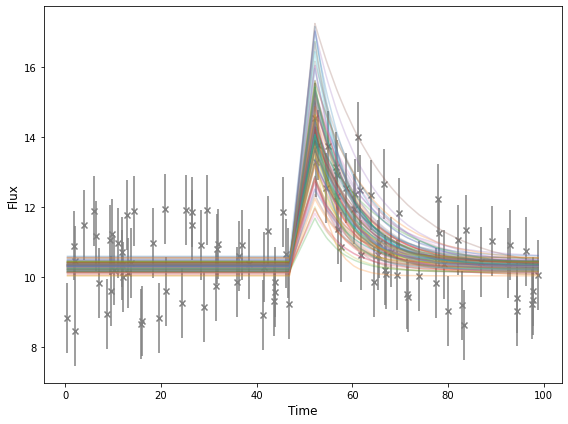

In [271]:
#CLD plotting all the models on top of the original data pts
fig, ax = plt.subplots(figsize=(8,6))
for model in models:
    ax.plot(time, model, alpha=0.25)
ax.scatter(time, flux, c='grey', marker='x')
ax.errorbar(time, flux, yerr=error, c='grey', fmt='none')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Flux', fontsize=12)
fig.tight_layout()
plt.show(fig);

## Part 7

In [229]:
#CLD first coding the new burst model
def burst_model_2(coeff, x):
    #CLD coefff should be in the order of [b, A, t_0, sig]
    y = coeff[0] + coeff[1]*np.exp(-(x - coeff[2])**2 / (2 * coeff[3]**2))
    return y

In [236]:
#CLD coding the priors and likelihood functions for the frist model (redoing bc of the cube thing)
def prior_transform(cube):
    params = cube.copy()
    
    #CLD transforming the b param
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo
    
    #CLD same priors on A so doing that transform
    params[1] = cube[1] * (hi - lo) + lo
    
    #CLD transforming the alpha param is this a log uniform prior?
    lo = -5
    hi = 5
    params[2] = (cube[2] * ((hi) - (lo)) + (lo))
    params[2] = np.exp(params[2])
    
    #CLD transforming the t_0 param
    lo = 0
    hi = 100
    params[3] = cube[3] * (hi - lo) + lo
    
    return params
    
def likelihood(params):
    y_fit = burst_model(params, time)
    L = np.sum(norm.logpdf(flux, y_fit, error))
    return L

In [237]:
#CLD now coding the priors and likelihood functions for the second model
def prior_transform_2(cube):
    params = cube.copy()
    
    #CLD transforming the b param
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo
    
    #CLD same priors on A so doing that transform
    params[1] = cube[1] * (hi - lo) + lo
    
    #CLD transforming the t_0 param
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo
    
    #CLD transforming the sig prior
    lo = -2
    hi = 2
    params[3] = (cube[3] * ((hi) - (lo)) + (lo))
    params[3] = np.exp(params[3])
    
    return params

def likelihood_2(params):
    fit = burst_model_2(params, time) #CLD fitting using the burst model
    L = np.sum(norm.logpdf(flux, fit, error))#CLD the likelihood with priors of the burst model
    return L


In [238]:
import ultranest
from ultranest.plot import cornerplot #CLD will be using as a check with MCMC reuslts above

In [239]:
param_names1 = ['b', 'A', r'$\alpha$', r'$t_0$']
param_names2 = ['b', 'A', r'$t_0$', r'$\sigma$']

In [240]:
#CLD setting up samplers
sampler1 = ultranest.ReactiveNestedSampler(param_names1, likelihood, 
                                          prior_transform)
sampler2 = ultranest.ReactiveNestedSampler(param_names2, likelihood_2, 
                                          prior_transform_2)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536
DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [241]:
#CLD running first sampler on the first model
result1 = sampler1.run()
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, logz=-inf, remainder_fraction=100.0000%, Lmin=-143373.86, Lmax=-179.34


DEBUG:ultranest:iteration=40, ncalls=442, logz=-69436.73, remainder_fraction=100.0000%, Lmin=-68692.58, Lmax=-179.34


DEBUG:ultranest:iteration=80, ncalls=484, logz=-56288.66, remainder_fraction=100.0000%, Lmin=-55587.89, Lmax=-179.34


DEBUG:ultranest:iteration=90, ncalls=495, logz=-53486.90, remainder_fraction=100.0000%, Lmin=-53431.83, Lmax=-179.34


DEBUG:ultranest:iteration=120, ncalls=528, logz=-46485.14, remainder_fraction=100.0000%, Lmin=-46435.18, Lmax=-179.34


DEBUG:ultranest:iteration=160, ncalls=578, logz=-37611.79, remainder_fraction=100.0000%, Lmin=-37440.72, Lmax=-179.34


DEBUG:ultranest:iteration=196, ncalls=633, logz=-30117.68, remainder_fraction=100.0000%, Lmin=-29991.73, Lmax=-179.34


DEBUG:ultranest:iteration=200, ncalls=642, logz=-28722.76, remainder_fraction=100.0000%, Lmin=-28586.53, Lmax=-179.34


DEBUG:ultranest:iteration=240, ncalls=701, logz=-22154.11, remainder_fraction=100.0000%, Lmin=-21930.11, Lmax=-179.34


DEBUG:ultranest:iteration=270, ncalls=748, logz=-18233.89, remainder_fraction=100.0000%, Lmin=-18177.78, Lmax=-172.73


DEBUG:ultranest:iteration=280, ncalls=760, logz=-17296.43, remainder_fraction=100.0000%, Lmin=-17194.94, Lmax=-172.73


DEBUG:ultranest:iteration=320, ncalls=807, logz=-12928.27, remainder_fraction=100.0000%, Lmin=-12654.70, Lmax=-172.73


DEBUG:ultranest:iteration=360, ncalls=860, logz=-9186.05, remainder_fraction=100.0000%, Lmin=-9175.96, Lmax=-172.73


DEBUG:ultranest:iteration=400, ncalls=913, logz=-7100.08, remainder_fraction=100.0000%, Lmin=-7053.65, Lmax=-172.73


DEBUG:ultranest:iteration=440, ncalls=974, logz=-5569.69, remainder_fraction=100.0000%, Lmin=-5553.70, Lmax=-172.73


DEBUG:ultranest:iteration=480, ncalls=1047, logz=-4504.66, remainder_fraction=100.0000%, Lmin=-4496.80, Lmax=-172.73


DEBUG:ultranest:iteration=520, ncalls=1110, logz=-3652.89, remainder_fraction=100.0000%, Lmin=-3639.10, Lmax=-172.73


DEBUG:ultranest:iteration=540, ncalls=1157, logz=-3382.90, remainder_fraction=100.0000%, Lmin=-3373.07, Lmax=-172.73


DEBUG:ultranest:iteration=560, ncalls=1187, logz=-3064.18, remainder_fraction=100.0000%, Lmin=-3046.27, Lmax=-172.73


DEBUG:ultranest:iteration=600, ncalls=1257, logz=-2753.84, remainder_fraction=100.0000%, Lmin=-2737.59, Lmax=-172.73


DEBUG:ultranest:iteration=630, ncalls=1313, logz=-2464.96, remainder_fraction=100.0000%, Lmin=-2448.53, Lmax=-172.73


DEBUG:ultranest:iteration=640, ncalls=1327, logz=-2385.23, remainder_fraction=100.0000%, Lmin=-2356.74, Lmax=-172.73


DEBUG:ultranest:iteration=680, ncalls=1399, logz=-1895.11, remainder_fraction=100.0000%, Lmin=-1860.68, Lmax=-172.73


DEBUG:ultranest:iteration=720, ncalls=1474, logz=-1663.21, remainder_fraction=100.0000%, Lmin=-1651.20, Lmax=-172.73


DEBUG:ultranest:iteration=760, ncalls=1556, logz=-1469.24, remainder_fraction=100.0000%, Lmin=-1454.86, Lmax=-172.73


DEBUG:ultranest:iteration=800, ncalls=1640, logz=-1293.37, remainder_fraction=100.0000%, Lmin=-1284.73, Lmax=-172.73


DEBUG:ultranest:iteration=810, ncalls=1657, logz=-1251.21, remainder_fraction=100.0000%, Lmin=-1238.34, Lmax=-172.73


DEBUG:ultranest:iteration=840, ncalls=1700, logz=-1096.44, remainder_fraction=100.0000%, Lmin=-1087.00, Lmax=-172.73


DEBUG:ultranest:iteration=880, ncalls=1778, logz=-968.58, remainder_fraction=100.0000%, Lmin=-958.41, Lmax=-172.73


DEBUG:ultranest:iteration=920, ncalls=1869, logz=-862.86, remainder_fraction=100.0000%, Lmin=-850.52, Lmax=-172.73


DEBUG:ultranest:iteration=960, ncalls=1970, logz=-758.42, remainder_fraction=100.0000%, Lmin=-749.04, Lmax=-172.73


DEBUG:ultranest:iteration=998, ncalls=2066, logz=-677.61, remainder_fraction=100.0000%, Lmin=-665.94, Lmax=-172.73


DEBUG:ultranest:iteration=1000, ncalls=2071, logz=-673.60, remainder_fraction=100.0000%, Lmin=-664.28, Lmax=-172.73


DEBUG:ultranest:iteration=1040, ncalls=2182, logz=-607.45, remainder_fraction=100.0000%, Lmin=-596.28, Lmax=-172.73


DEBUG:ultranest:iteration=1080, ncalls=2298, logz=-534.85, remainder_fraction=100.0000%, Lmin=-525.44, Lmax=-172.73


DEBUG:ultranest:iteration=1120, ncalls=2388, logz=-488.93, remainder_fraction=100.0000%, Lmin=-480.58, Lmax=-172.73


DEBUG:ultranest:iteration=1160, ncalls=2491, logz=-444.75, remainder_fraction=100.0000%, Lmin=-435.28, Lmax=-170.95


DEBUG:ultranest:iteration=1194, ncalls=2582, logz=-407.18, remainder_fraction=100.0000%, Lmin=-398.80, Lmax=-170.95


DEBUG:ultranest:iteration=1200, ncalls=2596, logz=-402.20, remainder_fraction=100.0000%, Lmin=-393.72, Lmax=-170.95


DEBUG:ultranest:iteration=1240, ncalls=2700, logz=-368.32, remainder_fraction=100.0000%, Lmin=-359.58, Lmax=-170.95


DEBUG:ultranest:iteration=1260, ncalls=2764, logz=-359.28, remainder_fraction=100.0000%, Lmin=-351.01, Lmax=-170.95


DEBUG:ultranest:iteration=1280, ncalls=2839, logz=-346.29, remainder_fraction=100.0000%, Lmin=-337.63, Lmax=-170.95


DEBUG:ultranest:iteration=1320, ncalls=2945, logz=-324.79, remainder_fraction=100.0000%, Lmin=-314.48, Lmax=-170.95


DEBUG:ultranest:iteration=1352, ncalls=3054, logz=-303.97, remainder_fraction=100.0000%, Lmin=-295.95, Lmax=-147.59


DEBUG:ultranest:iteration=1360, ncalls=3072, logz=-299.66, remainder_fraction=100.0000%, Lmin=-290.15, Lmax=-147.59


DEBUG:ultranest:iteration=1398, ncalls=3201, logz=-281.37, remainder_fraction=100.0000%, Lmin=-272.64, Lmax=-147.59


DEBUG:ultranest:iteration=1400, ncalls=3205, logz=-280.63, remainder_fraction=100.0000%, Lmin=-271.62, Lmax=-147.59


DEBUG:ultranest:iteration=1438, ncalls=3340, logz=-268.54, remainder_fraction=100.0000%, Lmin=-259.23, Lmax=-147.59


DEBUG:ultranest:iteration=1440, ncalls=3342, logz=-267.37, remainder_fraction=100.0000%, Lmin=-258.36, Lmax=-147.59


DEBUG:ultranest:iteration=1480, ncalls=3461, logz=-253.75, remainder_fraction=100.0000%, Lmin=-245.88, Lmax=-147.59


DEBUG:ultranest:iteration=1513, ncalls=3614, logz=-244.22, remainder_fraction=100.0000%, Lmin=-235.88, Lmax=-147.59


DEBUG:ultranest:iteration=1520, ncalls=3643, logz=-242.90, remainder_fraction=100.0000%, Lmin=-234.62, Lmax=-147.59


DEBUG:ultranest:iteration=1530, ncalls=3692, logz=-240.91, remainder_fraction=100.0000%, Lmin=-232.42, Lmax=-147.59


DEBUG:ultranest:iteration=1560, ncalls=3775, logz=-234.81, remainder_fraction=100.0000%, Lmin=-226.71, Lmax=-147.59


DEBUG:ultranest:iteration=1600, ncalls=3892, logz=-227.87, remainder_fraction=100.0000%, Lmin=-219.51, Lmax=-147.59


DEBUG:ultranest:iteration=1639, ncalls=3984, logz=-222.69, remainder_fraction=100.0000%, Lmin=-214.40, Lmax=-147.59


DEBUG:ultranest:iteration=1640, ncalls=3985, logz=-222.53, remainder_fraction=100.0000%, Lmin=-214.39, Lmax=-147.59


DEBUG:ultranest:iteration=1680, ncalls=4139, logz=-218.06, remainder_fraction=100.0000%, Lmin=-209.35, Lmax=-147.59


DEBUG:ultranest:iteration=1710, ncalls=4277, logz=-214.08, remainder_fraction=100.0000%, Lmin=-206.09, Lmax=-147.59


DEBUG:ultranest:iteration=1720, ncalls=4307, logz=-213.14, remainder_fraction=100.0000%, Lmin=-205.27, Lmax=-147.59


DEBUG:ultranest:iteration=1757, ncalls=4458, logz=-209.34, remainder_fraction=100.0000%, Lmin=-201.26, Lmax=-147.59


DEBUG:ultranest:iteration=1760, ncalls=4465, logz=-209.02, remainder_fraction=100.0000%, Lmin=-200.89, Lmax=-147.59


DEBUG:ultranest:iteration=1798, ncalls=4621, logz=-205.27, remainder_fraction=100.0000%, Lmin=-196.77, Lmax=-147.59


DEBUG:ultranest:iteration=1800, ncalls=4637, logz=-205.03, remainder_fraction=100.0000%, Lmin=-196.37, Lmax=-147.59


DEBUG:ultranest:iteration=1838, ncalls=4790, logz=-201.49, remainder_fraction=100.0000%, Lmin=-193.66, Lmax=-147.59


DEBUG:ultranest:iteration=1840, ncalls=4808, logz=-201.37, remainder_fraction=100.0000%, Lmin=-193.59, Lmax=-147.59


DEBUG:ultranest:iteration=1869, ncalls=4972, logz=-199.51, remainder_fraction=100.0000%, Lmin=-191.47, Lmax=-147.59


DEBUG:ultranest:iteration=1880, ncalls=5030, logz=-198.84, remainder_fraction=100.0000%, Lmin=-191.13, Lmax=-147.59


DEBUG:ultranest:iteration=1895, ncalls=5125, logz=-198.21, remainder_fraction=100.0000%, Lmin=-190.71, Lmax=-147.59


DEBUG:ultranest:iteration=1920, ncalls=5246, logz=-197.17, remainder_fraction=100.0000%, Lmin=-189.65, Lmax=-147.59


DEBUG:ultranest:iteration=1949, ncalls=5421, logz=-196.15, remainder_fraction=100.0000%, Lmin=-188.68, Lmax=-147.59


DEBUG:ultranest:iteration=1960, ncalls=5486, logz=-195.79, remainder_fraction=100.0000%, Lmin=-188.26, Lmax=-147.59


DEBUG:ultranest:iteration=1980, ncalls=5560, logz=-195.00, remainder_fraction=100.0000%, Lmin=-187.14, Lmax=-147.59


DEBUG:ultranest:iteration=2000, ncalls=5690, logz=-194.21, remainder_fraction=100.0000%, Lmin=-186.44, Lmax=-147.59


DEBUG:ultranest:iteration=2027, ncalls=5860, logz=-193.13, remainder_fraction=100.0000%, Lmin=-185.42, Lmax=-147.59


DEBUG:ultranest:iteration=2040, ncalls=5926, logz=-192.69, remainder_fraction=100.0000%, Lmin=-185.03, Lmax=-147.59


DEBUG:ultranest:iteration=2064, ncalls=6073, logz=-192.01, remainder_fraction=100.0000%, Lmin=-184.44, Lmax=-147.59


DEBUG:ultranest:iteration=2080, ncalls=6169, logz=-191.61, remainder_fraction=100.0000%, Lmin=-184.11, Lmax=-147.59


DEBUG:ultranest:iteration=2108, ncalls=6329, logz=-190.93, remainder_fraction=100.0000%, Lmin=-183.36, Lmax=-147.59


DEBUG:ultranest:iteration=2120, ncalls=6418, logz=-190.64, remainder_fraction=100.0000%, Lmin=-183.12, Lmax=-147.59


DEBUG:ultranest:iteration=2146, ncalls=6579, logz=-190.08, remainder_fraction=100.0000%, Lmin=-182.60, Lmax=-147.59


DEBUG:ultranest:iteration=2160, ncalls=6666, logz=-189.80, remainder_fraction=100.0000%, Lmin=-182.38, Lmax=-147.59


DEBUG:ultranest:iteration=2178, ncalls=6863, logz=-189.46, remainder_fraction=100.0000%, Lmin=-181.93, Lmax=-147.59


DEBUG:ultranest:iteration=2200, ncalls=7029, logz=-189.08, remainder_fraction=100.0000%, Lmin=-181.73, Lmax=-147.59


DEBUG:ultranest:iteration=2212, ncalls=7190, logz=-188.89, remainder_fraction=100.0000%, Lmin=-181.58, Lmax=-147.59


DEBUG:ultranest:iteration=2232, ncalls=7341, logz=-188.61, remainder_fraction=100.0000%, Lmin=-181.36, Lmax=-147.59


DEBUG:ultranest:iteration=2240, ncalls=7408, logz=-188.51, remainder_fraction=100.0000%, Lmin=-181.31, Lmax=-147.59


DEBUG:ultranest:iteration=2250, ncalls=7518, logz=-188.39, remainder_fraction=100.0000%, Lmin=-181.19, Lmax=-147.59


DEBUG:ultranest:iteration=2269, ncalls=7693, logz=-188.16, remainder_fraction=100.0000%, Lmin=-180.88, Lmax=-147.59


DEBUG:ultranest:iteration=2280, ncalls=7822, logz=-188.02, remainder_fraction=100.0000%, Lmin=-180.76, Lmax=-147.59


DEBUG:ultranest:iteration=2295, ncalls=7985, logz=-187.85, remainder_fraction=100.0000%, Lmin=-180.63, Lmax=-147.59


DEBUG:ultranest:iteration=2315, ncalls=8137, logz=-187.64, remainder_fraction=100.0000%, Lmin=-180.45, Lmax=-145.24


DEBUG:ultranest:iteration=2320, ncalls=8183, logz=-187.59, remainder_fraction=100.0000%, Lmin=-180.43, Lmax=-145.24


DEBUG:ultranest:iteration=2338, ncalls=8324, logz=-187.42, remainder_fraction=100.0000%, Lmin=-180.31, Lmax=-144.14


DEBUG:ultranest:iteration=2354, ncalls=8439, logz=-187.29, remainder_fraction=100.0000%, Lmin=-180.22, Lmax=-144.14


DEBUG:ultranest:iteration=2360, ncalls=8549, logz=-187.24, remainder_fraction=100.0000%, Lmin=-180.19, Lmax=-144.14


DEBUG:ultranest:iteration=2377, ncalls=8721, logz=-187.11, remainder_fraction=100.0000%, Lmin=-180.10, Lmax=-144.14


DEBUG:ultranest:iteration=2390, ncalls=8884, logz=-187.02, remainder_fraction=100.0000%, Lmin=-180.03, Lmax=-144.14


DEBUG:ultranest:iteration=2400, ncalls=8971, logz=-186.95, remainder_fraction=100.0000%, Lmin=-179.99, Lmax=-144.14


DEBUG:ultranest:iteration=2412, ncalls=9132, logz=-186.88, remainder_fraction=100.0000%, Lmin=-179.94, Lmax=-144.14


DEBUG:ultranest:iteration=2427, ncalls=9299, logz=-186.79, remainder_fraction=100.0000%, Lmin=-179.87, Lmax=-144.14


DEBUG:ultranest:iteration=2433, ncalls=9420, logz=-186.75, remainder_fraction=100.0000%, Lmin=-179.85, Lmax=-144.14


DEBUG:ultranest:iteration=2440, ncalls=9536, logz=-186.71, remainder_fraction=100.0000%, Lmin=-179.80, Lmax=-144.14


DEBUG:ultranest:iteration=2450, ncalls=9723, logz=-186.66, remainder_fraction=100.0000%, Lmin=-179.77, Lmax=-144.14


DEBUG:ultranest:iteration=2460, ncalls=9885, logz=-186.60, remainder_fraction=100.0000%, Lmin=-179.71, Lmax=-144.14


DEBUG:ultranest:iteration=2470, ncalls=10045, logz=-186.55, remainder_fraction=100.0000%, Lmin=-179.64, Lmax=-144.14


DEBUG:ultranest:iteration=2477, ncalls=10211, logz=-186.52, remainder_fraction=100.0000%, Lmin=-179.62, Lmax=-144.14


DEBUG:ultranest:iteration=2480, ncalls=10240, logz=-186.50, remainder_fraction=100.0000%, Lmin=-179.62, Lmax=-144.14


DEBUG:ultranest:iteration=2492, ncalls=10391, logz=-186.44, remainder_fraction=100.0000%, Lmin=-179.57, Lmax=-144.14


DEBUG:ultranest:iteration=2501, ncalls=10560, logz=-186.40, remainder_fraction=100.0000%, Lmin=-179.53, Lmax=-141.96


DEBUG:ultranest:iteration=2512, ncalls=10719, logz=-186.35, remainder_fraction=100.0000%, Lmin=-179.50, Lmax=-141.96


DEBUG:ultranest:iteration=2520, ncalls=10769, logz=-186.32, remainder_fraction=100.0000%, Lmin=-179.48, Lmax=-141.96


DEBUG:ultranest:iteration=2534, ncalls=11028, logz=-186.26, remainder_fraction=100.0000%, Lmin=-179.42, Lmax=-141.96


DEBUG:ultranest:iteration=2546, ncalls=11206, logz=-186.21, remainder_fraction=100.0000%, Lmin=-179.39, Lmax=-141.96


DEBUG:ultranest:iteration=2558, ncalls=11358, logz=-186.16, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-141.96


DEBUG:ultranest:iteration=2560, ncalls=11380, logz=-186.16, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-141.96


DEBUG:ultranest:iteration=2573, ncalls=11549, logz=-186.11, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-141.96


DEBUG:ultranest:iteration=2577, ncalls=11726, logz=-186.09, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-141.96


DEBUG:ultranest:iteration=2581, ncalls=11897, logz=-186.08, remainder_fraction=100.0000%, Lmin=-179.33, Lmax=-141.96


DEBUG:ultranest:iteration=2595, ncalls=12049, logz=-186.04, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-141.96


DEBUG:ultranest:iteration=2600, ncalls=12173, logz=-186.02, remainder_fraction=100.0000%, Lmin=-179.30, Lmax=-141.96


DEBUG:ultranest:iteration=2605, ncalls=12330, logz=-186.00, remainder_fraction=100.0000%, Lmin=-179.29, Lmax=-141.96


DEBUG:ultranest:iteration=2610, ncalls=12453, logz=-185.99, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-141.96


DEBUG:ultranest:iteration=2616, ncalls=12623, logz=-185.97, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-141.96


DEBUG:ultranest:iteration=2625, ncalls=12814, logz=-185.95, remainder_fraction=100.0000%, Lmin=-179.25, Lmax=-141.96


DEBUG:ultranest:iteration=2632, ncalls=13046, logz=-185.93, remainder_fraction=100.0000%, Lmin=-179.25, Lmax=-141.96


DEBUG:ultranest:iteration=2640, ncalls=13168, logz=-185.90, remainder_fraction=100.0000%, Lmin=-179.23, Lmax=-141.96


DEBUG:ultranest:iteration=2647, ncalls=13373, logz=-185.89, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-141.96


DEBUG:ultranest:iteration=2656, ncalls=13532, logz=-185.86, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-141.96


DEBUG:ultranest:iteration=2663, ncalls=13720, logz=-185.85, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-141.96


DEBUG:ultranest:iteration=2667, ncalls=13942, logz=-185.84, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-141.96


DEBUG:ultranest:iteration=2671, ncalls=14156, logz=-185.83, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-141.96


DEBUG:ultranest:iteration=2676, ncalls=14359, logz=-185.81, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-141.96


DEBUG:ultranest:iteration=2680, ncalls=14476, logz=-185.80, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-141.96


DEBUG:ultranest:iteration=2684, ncalls=14707, logz=-185.79, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-141.96


DEBUG:ultranest:iteration=2691, ncalls=14932, logz=-185.78, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-141.96


DEBUG:ultranest:iteration=2698, ncalls=15100, logz=-185.76, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-141.96


DEBUG:ultranest:iteration=2700, ncalls=15159, logz=-185.76, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-141.96


DEBUG:ultranest:iteration=2711, ncalls=15335, logz=-185.74, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-141.96


DEBUG:ultranest:iteration=2720, ncalls=15531, logz=-185.72, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-141.96


DEBUG:ultranest:iteration=2728, ncalls=15716, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-141.96


DEBUG:ultranest:iteration=2735, ncalls=15880, logz=-185.69, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-141.96


DEBUG:ultranest:iteration=2740, ncalls=16038, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-141.96


DEBUG:ultranest:iteration=2744, ncalls=16290, logz=-185.67, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-141.96


DEBUG:ultranest:iteration=2752, ncalls=16496, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-141.96


DEBUG:ultranest:iteration=2759, ncalls=16657, logz=-185.64, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-141.96


DEBUG:ultranest:iteration=2760, ncalls=16659, logz=-185.64, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-141.96


DEBUG:ultranest:iteration=2767, ncalls=16842, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-141.96


DEBUG:ultranest:iteration=2773, ncalls=17036, logz=-185.62, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-141.96


DEBUG:ultranest:iteration=2779, ncalls=17239, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-141.96


DEBUG:ultranest:iteration=2786, ncalls=17401, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-141.96
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=2794, ncalls=17504, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-141.96


DEBUG:ultranest:iteration=2800, ncalls=17592, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-141.96


DEBUG:ultranest:iteration=2805, ncalls=17779, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-141.96


DEBUG:ultranest:iteration=2814, ncalls=18013, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-141.96


DEBUG:ultranest:iteration=2821, ncalls=18226, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-141.96


DEBUG:ultranest:iteration=2824, ncalls=18446, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-141.96


DEBUG:ultranest:iteration=2827, ncalls=18624, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-141.96


DEBUG:ultranest:iteration=2834, ncalls=18865, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-141.96


DEBUG:ultranest:iteration=2839, ncalls=19069, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-141.96


DEBUG:ultranest:iteration=2840, ncalls=19085, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-141.96


DEBUG:ultranest:iteration=2845, ncalls=19257, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-141.96


DEBUG:ultranest:iteration=2852, ncalls=19513, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-141.96


DEBUG:ultranest:iteration=2859, ncalls=19713, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-141.96


DEBUG:ultranest:iteration=2866, ncalls=19882, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-141.96


DEBUG:ultranest:iteration=2869, ncalls=20054, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-141.96


DEBUG:ultranest:iteration=2873, ncalls=20431, logz=-185.47, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2878, ncalls=20646, logz=-185.47, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2880, ncalls=20788, logz=-185.47, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2883, ncalls=21040, logz=-185.46, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2887, ncalls=21346, logz=-185.46, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2895, ncalls=21494, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2897, ncalls=21661, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2900, ncalls=21883, logz=-185.44, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-141.96


DEBUG:ultranest:iteration=2903, ncalls=22225, logz=-185.44, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2910, ncalls=22388, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2913, ncalls=22566, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2914, ncalls=22821, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2918, ncalls=22985, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2920, ncalls=23086, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2927, ncalls=23277, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2931, ncalls=23438, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2933, ncalls=23686, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2935, ncalls=23845, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-141.96


DEBUG:ultranest:iteration=2940, ncalls=24055, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2945, ncalls=24285, logz=-185.40, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2950, ncalls=24446, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2954, ncalls=24887, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2956, ncalls=25167, logz=-185.39, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2960, ncalls=25311, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2964, ncalls=25482, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2967, ncalls=25719, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2968, ncalls=25898, logz=-185.38, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2970, ncalls=25943, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2973, ncalls=26152, logz=-185.37, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2981, ncalls=26358, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2983, ncalls=26509, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2987, ncalls=26773, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2992, ncalls=26928, logz=-185.36, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=2999, ncalls=27165, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3000, ncalls=27263, logz=-185.35, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3005, ncalls=27422, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3009, ncalls=27562, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3011, ncalls=27720, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3013, ncalls=27990, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3017, ncalls=28163, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3019, ncalls=28341, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3024, ncalls=28591, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-141.96


DEBUG:ultranest:iteration=3028, ncalls=28750, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3030, ncalls=28935, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3032, ncalls=29094, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3036, ncalls=29278, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3040, ncalls=29346, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3043, ncalls=29510, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3047, ncalls=29709, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3051, ncalls=29863, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3056, ncalls=30013, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3059, ncalls=30233, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3060, ncalls=30336, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3064, ncalls=30516, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3069, ncalls=30656, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3077, ncalls=30795, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3080, ncalls=30917, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3084, ncalls=31198, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3085, ncalls=31640, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3090, ncalls=31778, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3094, ncalls=32011, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-141.96


DEBUG:ultranest:iteration=3099, ncalls=32158, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-141.96


DEBUG:ultranest:iteration=3104, ncalls=32297, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-141.96


DEBUG:ultranest:iteration=3107, ncalls=32447, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-141.96


DEBUG:ultranest:iteration=3110, ncalls=32669, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-141.96


DEBUG:ultranest:iteration=3113, ncalls=32824, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-141.96


DEBUG:ultranest:iteration=3116, ncalls=33010, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-141.96


DEBUG:ultranest:iteration=3120, ncalls=33139, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.87, Lmax=-141.96


DEBUG:ultranest:iteration=3123, ncalls=33311, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.86, Lmax=-141.96


DEBUG:ultranest:iteration=3126, ncalls=33554, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.84, Lmax=-141.96


DEBUG:ultranest:iteration=3127, ncalls=33775, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.84, Lmax=-141.96


DEBUG:ultranest:iteration=3130, ncalls=33997, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.84, Lmax=-141.96


DEBUG:ultranest:iteration=3134, ncalls=34180, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-141.96


DEBUG:ultranest:iteration=3138, ncalls=34390, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.80, Lmax=-141.96


DEBUG:ultranest:iteration=3143, ncalls=34585, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.76, Lmax=-141.96


DEBUG:ultranest:iteration=3147, ncalls=34792, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.73, Lmax=-141.96


DEBUG:ultranest:iteration=3149, ncalls=35032, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.72, Lmax=-141.96


DEBUG:ultranest:iteration=3150, ncalls=35049, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.72, Lmax=-141.96


DEBUG:ultranest:iteration=3154, ncalls=35250, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.70, Lmax=-141.96


DEBUG:ultranest:iteration=3158, ncalls=35445, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.69, Lmax=-141.96


DEBUG:ultranest:iteration=3159, ncalls=35564, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.69, Lmax=-141.96


DEBUG:ultranest:iteration=3160, ncalls=35613, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-141.96


DEBUG:ultranest:iteration=3163, ncalls=35734, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-141.96


DEBUG:ultranest:iteration=3164, ncalls=35894, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-141.96


DEBUG:ultranest:iteration=3167, ncalls=36050, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.65, Lmax=-141.96


DEBUG:ultranest:iteration=3171, ncalls=36191, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.61, Lmax=-141.96


DEBUG:ultranest:iteration=3175, ncalls=36398, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.59, Lmax=-141.96


DEBUG:ultranest:iteration=3176, ncalls=36492, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.58, Lmax=-141.96


DEBUG:ultranest:iteration=3178, ncalls=36660, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.56, Lmax=-141.96


DEBUG:ultranest:iteration=3181, ncalls=36914, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.54, Lmax=-141.96


DEBUG:ultranest:iteration=3188, ncalls=37256, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.52, Lmax=-141.96


DEBUG:ultranest:iteration=3193, ncalls=37410, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.50, Lmax=-141.96


DEBUG:ultranest:iteration=3197, ncalls=37556, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.47, Lmax=-141.96


DEBUG:ultranest:iteration=3200, ncalls=37650, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.46, Lmax=-141.96


DEBUG:ultranest:iteration=3210, ncalls=37842, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.42, Lmax=-141.96


DEBUG:ultranest:iteration=3213, ncalls=38034, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.40, Lmax=-141.96


DEBUG:ultranest:iteration=3219, ncalls=38179, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.36, Lmax=-141.96


DEBUG:ultranest:iteration=3221, ncalls=38342, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.35, Lmax=-141.96


DEBUG:ultranest:iteration=3226, ncalls=38528, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.29, Lmax=-141.96


DEBUG:ultranest:iteration=3230, ncalls=38674, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.27, Lmax=-141.96


DEBUG:ultranest:iteration=3235, ncalls=38832, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.25, Lmax=-141.96


DEBUG:ultranest:iteration=3240, ncalls=38974, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.20, Lmax=-141.96


DEBUG:ultranest:iteration=3243, ncalls=39145, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.16, Lmax=-141.96


DEBUG:ultranest:iteration=3248, ncalls=39346, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.12, Lmax=-141.96


DEBUG:ultranest:iteration=3250, ncalls=39504, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.11, Lmax=-141.96


DEBUG:ultranest:iteration=3255, ncalls=39657, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.06, Lmax=-141.96


DEBUG:ultranest:iteration=3262, ncalls=39817, logz=-185.17, remainder_fraction=100.0000%, Lmin=-177.98, Lmax=-141.96


DEBUG:ultranest:iteration=3265, ncalls=40026, logz=-185.16, remainder_fraction=100.0000%, Lmin=-177.93, Lmax=-141.96


DEBUG:ultranest:iteration=3270, ncalls=40175, logz=-185.16, remainder_fraction=100.0000%, Lmin=-177.86, Lmax=-141.96


DEBUG:ultranest:iteration=3274, ncalls=40326, logz=-185.15, remainder_fraction=100.0000%, Lmin=-177.82, Lmax=-141.96


DEBUG:ultranest:iteration=3280, ncalls=40445, logz=-185.15, remainder_fraction=100.0000%, Lmin=-177.77, Lmax=-141.96


DEBUG:ultranest:iteration=3288, ncalls=40589, logz=-185.14, remainder_fraction=100.0000%, Lmin=-177.68, Lmax=-141.96


DEBUG:ultranest:iteration=3294, ncalls=40753, logz=-185.13, remainder_fraction=100.0000%, Lmin=-177.57, Lmax=-141.96


DEBUG:ultranest:iteration=3298, ncalls=40919, logz=-185.13, remainder_fraction=100.0000%, Lmin=-177.53, Lmax=-141.96


DEBUG:ultranest:iteration=3306, ncalls=41113, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.41, Lmax=-141.96


DEBUG:ultranest:iteration=3309, ncalls=41328, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.36, Lmax=-141.96


DEBUG:ultranest:iteration=3312, ncalls=41544, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.31, Lmax=-141.96


DEBUG:ultranest:iteration=3319, ncalls=41731, logz=-185.09, remainder_fraction=100.0000%, Lmin=-177.22, Lmax=-141.96


DEBUG:ultranest:iteration=3320, ncalls=41760, logz=-185.09, remainder_fraction=100.0000%, Lmin=-177.20, Lmax=-141.96


DEBUG:ultranest:iteration=3325, ncalls=41935, logz=-185.09, remainder_fraction=100.0000%, Lmin=-177.17, Lmax=-141.96


DEBUG:ultranest:iteration=3330, ncalls=42112, logz=-185.08, remainder_fraction=100.0000%, Lmin=-177.08, Lmax=-141.96


DEBUG:ultranest:iteration=3334, ncalls=42282, logz=-185.07, remainder_fraction=100.0000%, Lmin=-177.04, Lmax=-141.96


DEBUG:ultranest:iteration=3340, ncalls=42435, logz=-185.06, remainder_fraction=100.0000%, Lmin=-176.94, Lmax=-141.96


DEBUG:ultranest:iteration=3347, ncalls=42599, logz=-185.04, remainder_fraction=100.0000%, Lmin=-176.84, Lmax=-141.96


DEBUG:ultranest:iteration=3353, ncalls=42784, logz=-185.03, remainder_fraction=100.0000%, Lmin=-176.67, Lmax=-141.96


DEBUG:ultranest:iteration=3358, ncalls=42994, logz=-185.02, remainder_fraction=100.0000%, Lmin=-176.58, Lmax=-141.96


DEBUG:ultranest:iteration=3360, ncalls=43038, logz=-185.01, remainder_fraction=100.0000%, Lmin=-176.52, Lmax=-141.96


DEBUG:ultranest:iteration=3365, ncalls=43204, logz=-185.00, remainder_fraction=100.0000%, Lmin=-176.41, Lmax=-141.96


DEBUG:ultranest:iteration=3367, ncalls=43354, logz=-184.99, remainder_fraction=100.0000%, Lmin=-176.40, Lmax=-141.96


DEBUG:ultranest:iteration=3370, ncalls=43524, logz=-184.98, remainder_fraction=100.0000%, Lmin=-176.37, Lmax=-141.96


DEBUG:ultranest:iteration=3378, ncalls=43672, logz=-184.96, remainder_fraction=100.0000%, Lmin=-176.25, Lmax=-141.96


DEBUG:ultranest:iteration=3382, ncalls=43849, logz=-184.95, remainder_fraction=100.0000%, Lmin=-176.20, Lmax=-141.96


DEBUG:ultranest:iteration=3387, ncalls=44005, logz=-184.93, remainder_fraction=100.0000%, Lmin=-176.12, Lmax=-141.96


DEBUG:ultranest:iteration=3396, ncalls=44173, logz=-184.90, remainder_fraction=100.0000%, Lmin=-176.02, Lmax=-141.96


DEBUG:ultranest:iteration=3399, ncalls=44384, logz=-184.89, remainder_fraction=100.0000%, Lmin=-176.02, Lmax=-141.96


DEBUG:ultranest:iteration=3400, ncalls=44445, logz=-184.88, remainder_fraction=100.0000%, Lmin=-176.01, Lmax=-141.96


DEBUG:ultranest:iteration=3402, ncalls=44631, logz=-184.87, remainder_fraction=100.0000%, Lmin=-175.96, Lmax=-141.96


DEBUG:ultranest:iteration=3407, ncalls=44825, logz=-184.86, remainder_fraction=100.0000%, Lmin=-175.84, Lmax=-141.96


DEBUG:ultranest:iteration=3412, ncalls=45003, logz=-184.83, remainder_fraction=100.0000%, Lmin=-175.73, Lmax=-141.96


DEBUG:ultranest:iteration=3415, ncalls=45175, logz=-184.82, remainder_fraction=100.0000%, Lmin=-175.70, Lmax=-141.96


DEBUG:ultranest:iteration=3418, ncalls=45333, logz=-184.81, remainder_fraction=100.0000%, Lmin=-175.66, Lmax=-141.96


DEBUG:ultranest:iteration=3422, ncalls=45471, logz=-184.79, remainder_fraction=100.0000%, Lmin=-175.61, Lmax=-141.96


DEBUG:ultranest:iteration=3429, ncalls=45646, logz=-184.76, remainder_fraction=100.0000%, Lmin=-175.49, Lmax=-141.96


DEBUG:ultranest:iteration=3435, ncalls=45843, logz=-184.72, remainder_fraction=100.0000%, Lmin=-175.38, Lmax=-141.96


DEBUG:ultranest:iteration=3440, ncalls=45910, logz=-184.70, remainder_fraction=100.0000%, Lmin=-175.29, Lmax=-141.96


DEBUG:ultranest:iteration=3446, ncalls=46082, logz=-184.66, remainder_fraction=100.0000%, Lmin=-175.15, Lmax=-141.96


DEBUG:ultranest:iteration=3453, ncalls=46249, logz=-184.62, remainder_fraction=100.0000%, Lmin=-175.01, Lmax=-141.96


DEBUG:ultranest:iteration=3457, ncalls=46422, logz=-184.59, remainder_fraction=100.0000%, Lmin=-174.92, Lmax=-141.96


DEBUG:ultranest:iteration=3463, ncalls=46605, logz=-184.55, remainder_fraction=100.0000%, Lmin=-174.75, Lmax=-141.96


DEBUG:ultranest:iteration=3468, ncalls=46740, logz=-184.51, remainder_fraction=100.0000%, Lmin=-174.58, Lmax=-141.96


DEBUG:ultranest:iteration=3473, ncalls=46888, logz=-184.46, remainder_fraction=100.0000%, Lmin=-174.52, Lmax=-141.96


DEBUG:ultranest:iteration=3478, ncalls=47058, logz=-184.42, remainder_fraction=100.0000%, Lmin=-174.44, Lmax=-141.96


DEBUG:ultranest:iteration=3480, ncalls=47095, logz=-184.40, remainder_fraction=100.0000%, Lmin=-174.42, Lmax=-141.96


DEBUG:ultranest:iteration=3484, ncalls=47260, logz=-184.36, remainder_fraction=100.0000%, Lmin=-174.36, Lmax=-141.96


DEBUG:ultranest:iteration=3493, ncalls=47414, logz=-184.28, remainder_fraction=100.0000%, Lmin=-174.20, Lmax=-141.96


DEBUG:ultranest:iteration=3497, ncalls=47650, logz=-184.24, remainder_fraction=100.0000%, Lmin=-174.14, Lmax=-141.96


DEBUG:ultranest:iteration=3502, ncalls=47805, logz=-184.19, remainder_fraction=100.0000%, Lmin=-174.07, Lmax=-141.96


DEBUG:ultranest:iteration=3507, ncalls=47956, logz=-184.14, remainder_fraction=100.0000%, Lmin=-173.86, Lmax=-141.96


DEBUG:ultranest:iteration=3510, ncalls=48085, logz=-184.11, remainder_fraction=100.0000%, Lmin=-173.74, Lmax=-141.96


DEBUG:ultranest:iteration=3515, ncalls=48272, logz=-184.05, remainder_fraction=100.0000%, Lmin=-173.69, Lmax=-141.96


DEBUG:ultranest:iteration=3520, ncalls=48391, logz=-183.99, remainder_fraction=100.0000%, Lmin=-173.55, Lmax=-141.96


DEBUG:ultranest:iteration=3525, ncalls=48744, logz=-183.92, remainder_fraction=100.0000%, Lmin=-173.44, Lmax=-141.96


DEBUG:ultranest:iteration=3531, ncalls=48905, logz=-183.84, remainder_fraction=100.0000%, Lmin=-173.27, Lmax=-141.96


DEBUG:ultranest:iteration=3536, ncalls=49095, logz=-183.77, remainder_fraction=100.0000%, Lmin=-173.11, Lmax=-141.96


DEBUG:ultranest:iteration=3543, ncalls=49312, logz=-183.66, remainder_fraction=100.0000%, Lmin=-173.01, Lmax=-141.41


DEBUG:ultranest:iteration=3552, ncalls=49465, logz=-183.52, remainder_fraction=100.0000%, Lmin=-172.77, Lmax=-141.41


DEBUG:ultranest:iteration=3556, ncalls=49634, logz=-183.46, remainder_fraction=100.0000%, Lmin=-172.73, Lmax=-141.41


DEBUG:ultranest:iteration=3560, ncalls=49793, logz=-183.39, remainder_fraction=100.0000%, Lmin=-172.63, Lmax=-141.41


DEBUG:ultranest:iteration=3567, ncalls=49991, logz=-183.28, remainder_fraction=100.0000%, Lmin=-172.39, Lmax=-141.41


DEBUG:ultranest:iteration=3573, ncalls=50176, logz=-183.17, remainder_fraction=100.0000%, Lmin=-172.22, Lmax=-141.41


DEBUG:ultranest:iteration=3576, ncalls=50406, logz=-183.12, remainder_fraction=100.0000%, Lmin=-172.15, Lmax=-141.41


DEBUG:ultranest:iteration=3580, ncalls=50586, logz=-183.04, remainder_fraction=100.0000%, Lmin=-171.94, Lmax=-141.41


DEBUG:ultranest:iteration=3587, ncalls=50749, logz=-182.89, remainder_fraction=100.0000%, Lmin=-171.74, Lmax=-141.41


DEBUG:ultranest:iteration=3592, ncalls=50971, logz=-182.77, remainder_fraction=100.0000%, Lmin=-171.57, Lmax=-141.41


DEBUG:ultranest:iteration=3596, ncalls=51113, logz=-182.68, remainder_fraction=100.0000%, Lmin=-171.53, Lmax=-141.41


DEBUG:ultranest:iteration=3600, ncalls=51248, logz=-182.60, remainder_fraction=100.0000%, Lmin=-171.45, Lmax=-141.41


DEBUG:ultranest:iteration=3612, ncalls=51403, logz=-182.35, remainder_fraction=100.0000%, Lmin=-171.15, Lmax=-141.41


DEBUG:ultranest:iteration=3628, ncalls=51550, logz=-181.99, remainder_fraction=100.0000%, Lmin=-170.66, Lmax=-141.41


DEBUG:ultranest:iteration=3637, ncalls=51700, logz=-181.76, remainder_fraction=100.0000%, Lmin=-170.35, Lmax=-141.41


DEBUG:ultranest:iteration=3640, ncalls=51736, logz=-181.69, remainder_fraction=100.0000%, Lmin=-170.27, Lmax=-141.41


DEBUG:ultranest:iteration=3657, ncalls=51870, logz=-181.25, remainder_fraction=100.0000%, Lmin=-169.84, Lmax=-141.41


DEBUG:ultranest:iteration=3672, ncalls=52019, logz=-180.90, remainder_fraction=100.0000%, Lmin=-169.43, Lmax=-141.41


DEBUG:ultranest:iteration=3680, ncalls=52091, logz=-180.71, remainder_fraction=100.0000%, Lmin=-169.28, Lmax=-141.41


DEBUG:ultranest:iteration=3690, ncalls=52236, logz=-180.48, remainder_fraction=100.0000%, Lmin=-169.03, Lmax=-141.41


DEBUG:ultranest:iteration=3709, ncalls=52396, logz=-180.07, remainder_fraction=100.0000%, Lmin=-168.63, Lmax=-141.41


DEBUG:ultranest:iteration=3720, ncalls=52455, logz=-179.83, remainder_fraction=100.0000%, Lmin=-168.30, Lmax=-141.41


DEBUG:ultranest:iteration=3735, ncalls=52603, logz=-179.47, remainder_fraction=100.0000%, Lmin=-167.78, Lmax=-141.41


DEBUG:ultranest:iteration=3749, ncalls=52758, logz=-179.11, remainder_fraction=100.0000%, Lmin=-167.44, Lmax=-141.41


DEBUG:ultranest:iteration=3757, ncalls=52914, logz=-178.90, remainder_fraction=100.0000%, Lmin=-167.10, Lmax=-141.41


DEBUG:ultranest:iteration=3760, ncalls=52934, logz=-178.82, remainder_fraction=100.0000%, Lmin=-167.04, Lmax=-141.41


DEBUG:ultranest:iteration=3776, ncalls=53072, logz=-178.39, remainder_fraction=100.0000%, Lmin=-166.40, Lmax=-141.41


DEBUG:ultranest:iteration=3780, ncalls=53115, logz=-178.27, remainder_fraction=100.0000%, Lmin=-166.36, Lmax=-141.41


DEBUG:ultranest:iteration=3799, ncalls=53271, logz=-177.75, remainder_fraction=100.0000%, Lmin=-165.98, Lmax=-141.41


DEBUG:ultranest:iteration=3800, ncalls=53277, logz=-177.73, remainder_fraction=100.0000%, Lmin=-165.97, Lmax=-141.41


DEBUG:ultranest:iteration=3822, ncalls=53423, logz=-177.25, remainder_fraction=100.0000%, Lmin=-165.59, Lmax=-141.33


DEBUG:ultranest:iteration=3837, ncalls=53560, logz=-176.95, remainder_fraction=100.0000%, Lmin=-165.30, Lmax=-141.33


DEBUG:ultranest:iteration=3840, ncalls=53598, logz=-176.89, remainder_fraction=100.0000%, Lmin=-165.24, Lmax=-141.33


DEBUG:ultranest:iteration=3856, ncalls=53731, logz=-176.57, remainder_fraction=100.0000%, Lmin=-164.77, Lmax=-141.33


DEBUG:ultranest:iteration=3870, ncalls=53818, logz=-176.28, remainder_fraction=100.0000%, Lmin=-164.52, Lmax=-141.33


DEBUG:ultranest:iteration=3880, ncalls=53941, logz=-176.07, remainder_fraction=100.0000%, Lmin=-164.25, Lmax=-141.33


DEBUG:ultranest:iteration=3896, ncalls=54104, logz=-175.73, remainder_fraction=100.0000%, Lmin=-163.77, Lmax=-141.33


DEBUG:ultranest:iteration=3910, ncalls=54269, logz=-175.43, remainder_fraction=100.0000%, Lmin=-163.53, Lmax=-141.33


DEBUG:ultranest:iteration=3917, ncalls=54426, logz=-175.28, remainder_fraction=100.0000%, Lmin=-163.33, Lmax=-141.33


DEBUG:ultranest:iteration=3920, ncalls=54476, logz=-175.22, remainder_fraction=100.0000%, Lmin=-163.26, Lmax=-141.33


DEBUG:ultranest:iteration=3930, ncalls=54618, logz=-175.01, remainder_fraction=100.0000%, Lmin=-163.02, Lmax=-141.33


DEBUG:ultranest:iteration=3949, ncalls=54752, logz=-174.59, remainder_fraction=100.0000%, Lmin=-162.53, Lmax=-141.33


DEBUG:ultranest:iteration=3960, ncalls=54865, logz=-174.36, remainder_fraction=100.0000%, Lmin=-162.30, Lmax=-141.33


DEBUG:ultranest:iteration=3972, ncalls=54981, logz=-174.10, remainder_fraction=100.0000%, Lmin=-162.04, Lmax=-141.33


DEBUG:ultranest:iteration=3983, ncalls=55129, logz=-173.88, remainder_fraction=100.0000%, Lmin=-161.82, Lmax=-141.33


DEBUG:ultranest:iteration=3994, ncalls=55293, logz=-173.67, remainder_fraction=100.0000%, Lmin=-161.69, Lmax=-141.33


DEBUG:ultranest:iteration=4000, ncalls=55316, logz=-173.56, remainder_fraction=100.0000%, Lmin=-161.58, Lmax=-141.33


DEBUG:ultranest:iteration=4015, ncalls=55442, logz=-173.29, remainder_fraction=100.0000%, Lmin=-161.28, Lmax=-141.33


DEBUG:ultranest:iteration=4027, ncalls=55595, logz=-173.08, remainder_fraction=100.0000%, Lmin=-161.09, Lmax=-141.33


DEBUG:ultranest:iteration=4040, ncalls=55721, logz=-172.86, remainder_fraction=100.0000%, Lmin=-160.87, Lmax=-141.33


DEBUG:ultranest:iteration=4050, ncalls=55852, logz=-172.71, remainder_fraction=100.0000%, Lmin=-160.80, Lmax=-141.33


DEBUG:ultranest:iteration=4065, ncalls=56006, logz=-172.49, remainder_fraction=100.0000%, Lmin=-160.58, Lmax=-141.33


DEBUG:ultranest:iteration=4078, ncalls=56149, logz=-172.30, remainder_fraction=100.0000%, Lmin=-160.29, Lmax=-141.33


DEBUG:ultranest:iteration=4080, ncalls=56158, logz=-172.27, remainder_fraction=100.0000%, Lmin=-160.24, Lmax=-141.33


DEBUG:ultranest:iteration=4094, ncalls=56296, logz=-172.03, remainder_fraction=100.0000%, Lmin=-159.82, Lmax=-141.33


DEBUG:ultranest:iteration=4110, ncalls=56426, logz=-171.75, remainder_fraction=100.0000%, Lmin=-159.43, Lmax=-141.33


DEBUG:ultranest:iteration=4120, ncalls=56493, logz=-171.56, remainder_fraction=100.0000%, Lmin=-159.35, Lmax=-141.33


DEBUG:ultranest:iteration=4131, ncalls=56637, logz=-171.38, remainder_fraction=100.0000%, Lmin=-159.19, Lmax=-141.33


DEBUG:ultranest:iteration=4140, ncalls=56694, logz=-171.24, remainder_fraction=100.0000%, Lmin=-159.00, Lmax=-140.96


DEBUG:ultranest:iteration=4152, ncalls=56847, logz=-171.04, remainder_fraction=100.0000%, Lmin=-158.75, Lmax=-140.96


DEBUG:ultranest:iteration=4160, ncalls=56927, logz=-170.90, remainder_fraction=100.0000%, Lmin=-158.55, Lmax=-140.96


DEBUG:ultranest:iteration=4173, ncalls=57083, logz=-170.67, remainder_fraction=100.0000%, Lmin=-158.19, Lmax=-140.96


DEBUG:ultranest:iteration=4186, ncalls=57217, logz=-170.42, remainder_fraction=100.0000%, Lmin=-157.97, Lmax=-140.96


DEBUG:ultranest:iteration=4200, ncalls=57323, logz=-170.17, remainder_fraction=100.0000%, Lmin=-157.73, Lmax=-140.96


DEBUG:ultranest:iteration=4217, ncalls=57479, logz=-169.86, remainder_fraction=100.0000%, Lmin=-157.34, Lmax=-140.96


DEBUG:ultranest:iteration=4230, ncalls=57584, logz=-169.64, remainder_fraction=99.9999%, Lmin=-157.09, Lmax=-140.96


DEBUG:ultranest:iteration=4240, ncalls=57720, logz=-169.46, remainder_fraction=99.9999%, Lmin=-156.83, Lmax=-140.96


DEBUG:ultranest:iteration=4251, ncalls=57867, logz=-169.24, remainder_fraction=99.9999%, Lmin=-156.53, Lmax=-140.96


DEBUG:ultranest:iteration=4267, ncalls=58008, logz=-168.90, remainder_fraction=99.9999%, Lmin=-156.08, Lmax=-140.96


DEBUG:ultranest:iteration=4280, ncalls=58126, logz=-168.64, remainder_fraction=99.9998%, Lmin=-155.88, Lmax=-140.96


DEBUG:ultranest:iteration=4294, ncalls=58280, logz=-168.36, remainder_fraction=99.9998%, Lmin=-155.51, Lmax=-140.96


DEBUG:ultranest:iteration=4315, ncalls=58422, logz=-167.95, remainder_fraction=99.9997%, Lmin=-155.19, Lmax=-140.96


DEBUG:ultranest:iteration=4320, ncalls=58457, logz=-167.86, remainder_fraction=99.9996%, Lmin=-155.06, Lmax=-140.96


DEBUG:ultranest:iteration=4338, ncalls=58610, logz=-167.54, remainder_fraction=99.9995%, Lmin=-154.75, Lmax=-140.96


DEBUG:ultranest:iteration=4350, ncalls=58786, logz=-167.33, remainder_fraction=99.9993%, Lmin=-154.56, Lmax=-140.96


DEBUG:ultranest:iteration=4360, ncalls=58870, logz=-167.17, remainder_fraction=99.9992%, Lmin=-154.40, Lmax=-140.96


DEBUG:ultranest:iteration=4369, ncalls=59013, logz=-167.02, remainder_fraction=99.9991%, Lmin=-154.16, Lmax=-140.96


DEBUG:ultranest:iteration=4377, ncalls=59165, logz=-166.88, remainder_fraction=99.9990%, Lmin=-154.00, Lmax=-140.96


DEBUG:ultranest:iteration=4388, ncalls=59307, logz=-166.70, remainder_fraction=99.9988%, Lmin=-153.81, Lmax=-140.96


DEBUG:ultranest:iteration=4400, ncalls=59378, logz=-166.48, remainder_fraction=99.9985%, Lmin=-153.45, Lmax=-140.96


DEBUG:ultranest:iteration=4410, ncalls=59468, logz=-166.29, remainder_fraction=99.9982%, Lmin=-153.24, Lmax=-140.96


DEBUG:ultranest:iteration=4428, ncalls=59601, logz=-165.95, remainder_fraction=99.9974%, Lmin=-152.93, Lmax=-140.96


DEBUG:ultranest:iteration=4440, ncalls=59696, logz=-165.75, remainder_fraction=99.9967%, Lmin=-152.77, Lmax=-140.96


DEBUG:ultranest:iteration=4460, ncalls=59833, logz=-165.42, remainder_fraction=99.9954%, Lmin=-152.37, Lmax=-140.96


DEBUG:ultranest:iteration=4479, ncalls=59955, logz=-165.12, remainder_fraction=99.9939%, Lmin=-152.11, Lmax=-140.96


DEBUG:ultranest:iteration=4480, ncalls=59956, logz=-165.11, remainder_fraction=99.9938%, Lmin=-152.11, Lmax=-140.96


DEBUG:ultranest:iteration=4495, ncalls=60083, logz=-164.89, remainder_fraction=99.9925%, Lmin=-151.91, Lmax=-140.96


DEBUG:ultranest:iteration=4511, ncalls=60176, logz=-164.66, remainder_fraction=99.9906%, Lmin=-151.58, Lmax=-140.96


DEBUG:ultranest:iteration=4520, ncalls=60238, logz=-164.52, remainder_fraction=99.9896%, Lmin=-151.46, Lmax=-140.96


DEBUG:ultranest:iteration=4537, ncalls=60400, logz=-164.26, remainder_fraction=99.9861%, Lmin=-151.06, Lmax=-140.96


DEBUG:ultranest:iteration=4555, ncalls=60541, logz=-163.99, remainder_fraction=99.9822%, Lmin=-150.78, Lmax=-140.96


DEBUG:ultranest:iteration=4560, ncalls=60589, logz=-163.91, remainder_fraction=99.9811%, Lmin=-150.73, Lmax=-140.96


DEBUG:ultranest:iteration=4575, ncalls=60726, logz=-163.69, remainder_fraction=99.9761%, Lmin=-150.54, Lmax=-140.96


DEBUG:ultranest:iteration=4590, ncalls=60891, logz=-163.49, remainder_fraction=99.9718%, Lmin=-150.30, Lmax=-140.96


DEBUG:ultranest:iteration=4600, ncalls=60944, logz=-163.35, remainder_fraction=99.9670%, Lmin=-150.17, Lmax=-140.96


DEBUG:ultranest:iteration=4623, ncalls=61097, logz=-163.03, remainder_fraction=99.9529%, Lmin=-149.79, Lmax=-140.96


DEBUG:ultranest:iteration=4639, ncalls=61257, logz=-162.83, remainder_fraction=99.9458%, Lmin=-149.69, Lmax=-140.96


DEBUG:ultranest:iteration=4640, ncalls=61259, logz=-162.82, remainder_fraction=99.9450%, Lmin=-149.65, Lmax=-140.96


DEBUG:ultranest:iteration=4652, ncalls=61412, logz=-162.67, remainder_fraction=99.9359%, Lmin=-149.43, Lmax=-140.96


DEBUG:ultranest:iteration=4667, ncalls=61556, logz=-162.48, remainder_fraction=99.9213%, Lmin=-149.07, Lmax=-140.96


DEBUG:ultranest:iteration=4680, ncalls=61707, logz=-162.30, remainder_fraction=99.9044%, Lmin=-148.83, Lmax=-140.96


DEBUG:ultranest:iteration=4696, ncalls=61870, logz=-162.06, remainder_fraction=99.8782%, Lmin=-148.52, Lmax=-140.96


DEBUG:ultranest:iteration=4709, ncalls=62026, logz=-161.87, remainder_fraction=99.8597%, Lmin=-148.40, Lmax=-140.87


DEBUG:ultranest:iteration=4720, ncalls=62115, logz=-161.73, remainder_fraction=99.8347%, Lmin=-148.29, Lmax=-140.87


DEBUG:ultranest:iteration=4738, ncalls=62255, logz=-161.51, remainder_fraction=99.7957%, Lmin=-148.13, Lmax=-140.87


DEBUG:ultranest:iteration=4751, ncalls=62397, logz=-161.36, remainder_fraction=99.7577%, Lmin=-147.98, Lmax=-140.87


DEBUG:ultranest:iteration=4760, ncalls=62498, logz=-161.27, remainder_fraction=99.7295%, Lmin=-147.91, Lmax=-140.87


DEBUG:ultranest:iteration=4770, ncalls=62648, logz=-161.16, remainder_fraction=99.6956%, Lmin=-147.84, Lmax=-140.87


DEBUG:ultranest:iteration=4798, ncalls=62778, logz=-160.88, remainder_fraction=99.5780%, Lmin=-147.54, Lmax=-140.87


DEBUG:ultranest:iteration=4800, ncalls=62782, logz=-160.86, remainder_fraction=99.5699%, Lmin=-147.53, Lmax=-140.87


DEBUG:ultranest:iteration=4831, ncalls=62894, logz=-160.59, remainder_fraction=99.4573%, Lmin=-147.28, Lmax=-140.76


DEBUG:ultranest:iteration=4840, ncalls=62922, logz=-160.51, remainder_fraction=99.4177%, Lmin=-147.12, Lmax=-140.76


DEBUG:ultranest:iteration=4860, ncalls=63021, logz=-160.33, remainder_fraction=99.3160%, Lmin=-146.93, Lmax=-140.76


DEBUG:ultranest:iteration=4880, ncalls=63119, logz=-160.14, remainder_fraction=99.1864%, Lmin=-146.63, Lmax=-140.76


DEBUG:ultranest:iteration=4899, ncalls=63242, logz=-159.97, remainder_fraction=99.0330%, Lmin=-146.44, Lmax=-140.76


DEBUG:ultranest:iteration=4920, ncalls=63363, logz=-159.78, remainder_fraction=98.8459%, Lmin=-146.23, Lmax=-140.76


DEBUG:ultranest:iteration=4942, ncalls=63498, logz=-159.60, remainder_fraction=98.6065%, Lmin=-146.08, Lmax=-140.76


DEBUG:ultranest:iteration=4960, ncalls=63545, logz=-159.46, remainder_fraction=98.4132%, Lmin=-145.94, Lmax=-140.76


DEBUG:ultranest:iteration=4985, ncalls=63685, logz=-159.28, remainder_fraction=98.1095%, Lmin=-145.80, Lmax=-140.76


DEBUG:ultranest:iteration=5000, ncalls=63742, logz=-159.17, remainder_fraction=97.9020%, Lmin=-145.66, Lmax=-140.74


DEBUG:ultranest:iteration=5034, ncalls=63864, logz=-158.94, remainder_fraction=97.2991%, Lmin=-145.38, Lmax=-140.74


DEBUG:ultranest:iteration=5040, ncalls=63893, logz=-158.90, remainder_fraction=97.1925%, Lmin=-145.32, Lmax=-140.74


DEBUG:ultranest:iteration=5069, ncalls=64036, logz=-158.72, remainder_fraction=96.5874%, Lmin=-145.12, Lmax=-140.68


DEBUG:ultranest:iteration=5080, ncalls=64089, logz=-158.65, remainder_fraction=96.2999%, Lmin=-145.05, Lmax=-140.68


DEBUG:ultranest:iteration=5100, ncalls=64222, logz=-158.53, remainder_fraction=95.9352%, Lmin=-144.91, Lmax=-140.68


DEBUG:ultranest:iteration=5120, ncalls=64338, logz=-158.41, remainder_fraction=95.4285%, Lmin=-144.76, Lmax=-140.68


DEBUG:ultranest:iteration=5134, ncalls=64424, logz=-158.33, remainder_fraction=95.0673%, Lmin=-144.65, Lmax=-140.68


DEBUG:ultranest:iteration=5160, ncalls=64550, logz=-158.18, remainder_fraction=94.2440%, Lmin=-144.52, Lmax=-140.68


DEBUG:ultranest:iteration=5181, ncalls=64696, logz=-158.08, remainder_fraction=93.5649%, Lmin=-144.43, Lmax=-140.67


DEBUG:ultranest:iteration=5200, ncalls=64782, logz=-157.98, remainder_fraction=92.8337%, Lmin=-144.33, Lmax=-140.67


DEBUG:ultranest:iteration=5217, ncalls=64928, logz=-157.90, remainder_fraction=92.2275%, Lmin=-144.19, Lmax=-140.67


DEBUG:ultranest:iteration=5220, ncalls=64958, logz=-157.89, remainder_fraction=92.1226%, Lmin=-144.17, Lmax=-140.67


DEBUG:ultranest:iteration=5240, ncalls=65056, logz=-157.79, remainder_fraction=91.3936%, Lmin=-144.07, Lmax=-140.67


DEBUG:ultranest:iteration=5272, ncalls=65194, logz=-157.65, remainder_fraction=90.0070%, Lmin=-143.90, Lmax=-140.67


DEBUG:ultranest:iteration=5280, ncalls=65245, logz=-157.61, remainder_fraction=89.6110%, Lmin=-143.84, Lmax=-140.67


DEBUG:ultranest:iteration=5300, ncalls=65368, logz=-157.53, remainder_fraction=88.8844%, Lmin=-143.74, Lmax=-140.67


DEBUG:ultranest:iteration=5316, ncalls=65453, logz=-157.46, remainder_fraction=88.1261%, Lmin=-143.66, Lmax=-140.67


DEBUG:ultranest:iteration=5320, ncalls=65473, logz=-157.44, remainder_fraction=87.9622%, Lmin=-143.65, Lmax=-140.67


DEBUG:ultranest:iteration=5345, ncalls=65618, logz=-157.35, remainder_fraction=86.6435%, Lmin=-143.58, Lmax=-140.67


DEBUG:ultranest:iteration=5360, ncalls=65737, logz=-157.29, remainder_fraction=85.8678%, Lmin=-143.50, Lmax=-140.67


DEBUG:ultranest:iteration=5378, ncalls=65875, logz=-157.22, remainder_fraction=84.8392%, Lmin=-143.41, Lmax=-140.67


DEBUG:ultranest:iteration=5400, ncalls=66003, logz=-157.15, remainder_fraction=83.5371%, Lmin=-143.33, Lmax=-140.67


DEBUG:ultranest:iteration=5426, ncalls=66160, logz=-157.06, remainder_fraction=82.1289%, Lmin=-143.22, Lmax=-140.67


DEBUG:ultranest:iteration=5440, ncalls=66235, logz=-157.01, remainder_fraction=81.1679%, Lmin=-143.18, Lmax=-140.67


DEBUG:ultranest:iteration=5464, ncalls=66370, logz=-156.94, remainder_fraction=79.7662%, Lmin=-143.06, Lmax=-140.67


DEBUG:ultranest:iteration=5480, ncalls=66449, logz=-156.89, remainder_fraction=78.7255%, Lmin=-143.01, Lmax=-140.67


DEBUG:ultranest:iteration=5490, ncalls=66499, logz=-156.86, remainder_fraction=78.0923%, Lmin=-142.97, Lmax=-140.67


DEBUG:ultranest:iteration=5507, ncalls=66631, logz=-156.81, remainder_fraction=76.8336%, Lmin=-142.92, Lmax=-140.67


DEBUG:ultranest:iteration=5520, ncalls=66701, logz=-156.77, remainder_fraction=75.7922%, Lmin=-142.87, Lmax=-140.67


DEBUG:ultranest:iteration=5546, ncalls=66823, logz=-156.70, remainder_fraction=74.1985%, Lmin=-142.80, Lmax=-140.67


DEBUG:ultranest:iteration=5560, ncalls=66900, logz=-156.67, remainder_fraction=73.1307%, Lmin=-142.75, Lmax=-140.67


DEBUG:ultranest:iteration=5580, ncalls=66995, logz=-156.62, remainder_fraction=71.8026%, Lmin=-142.67, Lmax=-140.67


DEBUG:ultranest:iteration=5600, ncalls=67093, logz=-156.57, remainder_fraction=70.3588%, Lmin=-142.60, Lmax=-140.67


DEBUG:ultranest:iteration=5630, ncalls=67229, logz=-156.50, remainder_fraction=68.3875%, Lmin=-142.49, Lmax=-140.67


DEBUG:ultranest:iteration=5640, ncalls=67262, logz=-156.47, remainder_fraction=67.6854%, Lmin=-142.46, Lmax=-140.67


DEBUG:ultranest:iteration=5661, ncalls=67388, logz=-156.43, remainder_fraction=66.2200%, Lmin=-142.41, Lmax=-140.67


DEBUG:ultranest:iteration=5675, ncalls=67496, logz=-156.40, remainder_fraction=65.1164%, Lmin=-142.38, Lmax=-140.67


DEBUG:ultranest:iteration=5680, ncalls=67532, logz=-156.39, remainder_fraction=64.6748%, Lmin=-142.37, Lmax=-140.67


DEBUG:ultranest:iteration=5703, ncalls=67662, logz=-156.34, remainder_fraction=62.9329%, Lmin=-142.28, Lmax=-140.67


DEBUG:ultranest:iteration=5720, ncalls=67779, logz=-156.31, remainder_fraction=61.6725%, Lmin=-142.24, Lmax=-140.66


DEBUG:ultranest:iteration=5740, ncalls=67918, logz=-156.27, remainder_fraction=60.1858%, Lmin=-142.19, Lmax=-140.66


DEBUG:ultranest:iteration=5760, ncalls=68027, logz=-156.23, remainder_fraction=58.9627%, Lmin=-142.14, Lmax=-140.66


DEBUG:ultranest:iteration=5785, ncalls=68166, logz=-156.18, remainder_fraction=56.9145%, Lmin=-142.08, Lmax=-140.66


DEBUG:ultranest:iteration=5800, ncalls=68280, logz=-156.16, remainder_fraction=55.6746%, Lmin=-142.05, Lmax=-140.66


DEBUG:ultranest:iteration=5823, ncalls=68415, logz=-156.12, remainder_fraction=53.9259%, Lmin=-142.01, Lmax=-140.66


DEBUG:ultranest:iteration=5840, ncalls=68490, logz=-156.09, remainder_fraction=52.5374%, Lmin=-141.97, Lmax=-140.66


DEBUG:ultranest:iteration=5850, ncalls=68570, logz=-156.08, remainder_fraction=51.8568%, Lmin=-141.96, Lmax=-140.66


DEBUG:ultranest:iteration=5870, ncalls=68689, logz=-156.05, remainder_fraction=50.4519%, Lmin=-141.92, Lmax=-140.66


DEBUG:ultranest:iteration=5880, ncalls=68733, logz=-156.04, remainder_fraction=49.6306%, Lmin=-141.91, Lmax=-140.66


DEBUG:ultranest:iteration=5902, ncalls=68868, logz=-156.01, remainder_fraction=48.1249%, Lmin=-141.89, Lmax=-140.66


DEBUG:ultranest:iteration=5920, ncalls=68970, logz=-155.98, remainder_fraction=46.8263%, Lmin=-141.83, Lmax=-140.66


DEBUG:ultranest:iteration=5940, ncalls=69073, logz=-155.96, remainder_fraction=45.4589%, Lmin=-141.80, Lmax=-140.66


DEBUG:ultranest:iteration=5960, ncalls=69177, logz=-155.93, remainder_fraction=44.1287%, Lmin=-141.75, Lmax=-140.66


DEBUG:ultranest:iteration=5990, ncalls=69320, logz=-155.90, remainder_fraction=42.1252%, Lmin=-141.71, Lmax=-140.66


DEBUG:ultranest:iteration=6000, ncalls=69387, logz=-155.88, remainder_fraction=41.4112%, Lmin=-141.68, Lmax=-140.66


DEBUG:ultranest:iteration=6022, ncalls=69514, logz=-155.86, remainder_fraction=39.9747%, Lmin=-141.65, Lmax=-140.66
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=6037, ncalls=69596, logz=-155.84, remainder_fraction=38.9690%, Lmin=-141.62, Lmax=-140.66


DEBUG:ultranest:iteration=6040, ncalls=69619, logz=-155.84, remainder_fraction=38.8002%, Lmin=-141.62, Lmax=-140.66


DEBUG:ultranest:iteration=6063, ncalls=69754, logz=-155.82, remainder_fraction=37.3871%, Lmin=-141.59, Lmax=-140.66


DEBUG:ultranest:iteration=6080, ncalls=69815, logz=-155.80, remainder_fraction=36.4389%, Lmin=-141.57, Lmax=-140.66


DEBUG:ultranest:iteration=6103, ncalls=69937, logz=-155.78, remainder_fraction=34.9605%, Lmin=-141.53, Lmax=-140.66
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=6120, ncalls=70039, logz=-155.77, remainder_fraction=33.9330%, Lmin=-141.50, Lmax=-140.66


DEBUG:ultranest:iteration=6144, ncalls=70210, logz=-155.74, remainder_fraction=32.4924%, Lmin=-141.45, Lmax=-140.66


DEBUG:ultranest:iteration=6160, ncalls=70313, logz=-155.73, remainder_fraction=31.5473%, Lmin=-141.43, Lmax=-140.66


DEBUG:ultranest:iteration=6175, ncalls=70426, logz=-155.72, remainder_fraction=30.6807%, Lmin=-141.41, Lmax=-140.66


DEBUG:ultranest:iteration=6193, ncalls=70519, logz=-155.70, remainder_fraction=29.6420%, Lmin=-141.38, Lmax=-140.66


DEBUG:ultranest:iteration=6200, ncalls=70584, logz=-155.70, remainder_fraction=29.2594%, Lmin=-141.37, Lmax=-140.66


DEBUG:ultranest:iteration=6210, ncalls=70624, logz=-155.69, remainder_fraction=28.6857%, Lmin=-141.36, Lmax=-140.66


DEBUG:ultranest:iteration=6222, ncalls=70704, logz=-155.68, remainder_fraction=28.0058%, Lmin=-141.35, Lmax=-140.66


DEBUG:ultranest:iteration=6233, ncalls=70773, logz=-155.67, remainder_fraction=27.4685%, Lmin=-141.33, Lmax=-140.66


DEBUG:ultranest:iteration=6240, ncalls=70809, logz=-155.67, remainder_fraction=27.1004%, Lmin=-141.33, Lmax=-140.66


DEBUG:ultranest:iteration=6259, ncalls=70919, logz=-155.66, remainder_fraction=26.1419%, Lmin=-141.31, Lmax=-140.66


DEBUG:ultranest:iteration=6275, ncalls=71029, logz=-155.64, remainder_fraction=25.3365%, Lmin=-141.30, Lmax=-140.66


DEBUG:ultranest:iteration=6280, ncalls=71055, logz=-155.64, remainder_fraction=25.0965%, Lmin=-141.29, Lmax=-140.66


DEBUG:ultranest:iteration=6292, ncalls=71163, logz=-155.63, remainder_fraction=24.5026%, Lmin=-141.28, Lmax=-140.66


DEBUG:ultranest:iteration=6303, ncalls=71240, logz=-155.63, remainder_fraction=24.0022%, Lmin=-141.26, Lmax=-140.66


DEBUG:ultranest:iteration=6320, ncalls=71331, logz=-155.62, remainder_fraction=23.3073%, Lmin=-141.25, Lmax=-140.66


DEBUG:ultranest:iteration=6338, ncalls=71419, logz=-155.61, remainder_fraction=22.4931%, Lmin=-141.23, Lmax=-140.66


DEBUG:ultranest:iteration=6345, ncalls=71516, logz=-155.60, remainder_fraction=22.1836%, Lmin=-141.23, Lmax=-140.66


DEBUG:ultranest:iteration=6355, ncalls=71591, logz=-155.60, remainder_fraction=21.7579%, Lmin=-141.22, Lmax=-140.66


DEBUG:ultranest:iteration=6360, ncalls=71641, logz=-155.59, remainder_fraction=21.5448%, Lmin=-141.21, Lmax=-140.66


DEBUG:ultranest:iteration=6377, ncalls=71746, logz=-155.58, remainder_fraction=20.8183%, Lmin=-141.19, Lmax=-140.66


DEBUG:ultranest:iteration=6390, ncalls=71837, logz=-155.58, remainder_fraction=20.3083%, Lmin=-141.19, Lmax=-140.66


DEBUG:ultranest:iteration=6400, ncalls=71892, logz=-155.57, remainder_fraction=19.9007%, Lmin=-141.18, Lmax=-140.66


DEBUG:ultranest:iteration=6423, ncalls=72028, logz=-155.56, remainder_fraction=18.9796%, Lmin=-141.16, Lmax=-140.66


DEBUG:ultranest:iteration=6440, ncalls=72161, logz=-155.55, remainder_fraction=18.3160%, Lmin=-141.15, Lmax=-140.66


DEBUG:ultranest:iteration=6460, ncalls=72286, logz=-155.54, remainder_fraction=17.5831%, Lmin=-141.14, Lmax=-140.66


DEBUG:ultranest:iteration=6480, ncalls=72403, logz=-155.54, remainder_fraction=16.8730%, Lmin=-141.12, Lmax=-140.66


DEBUG:ultranest:iteration=6508, ncalls=72544, logz=-155.52, remainder_fraction=15.9027%, Lmin=-141.10, Lmax=-140.66


DEBUG:ultranest:iteration=6520, ncalls=72622, logz=-155.52, remainder_fraction=15.5118%, Lmin=-141.10, Lmax=-140.66


DEBUG:ultranest:iteration=6549, ncalls=72748, logz=-155.51, remainder_fraction=14.6084%, Lmin=-141.08, Lmax=-140.66


DEBUG:ultranest:iteration=6560, ncalls=72810, logz=-155.51, remainder_fraction=14.2439%, Lmin=-141.07, Lmax=-140.66


DEBUG:ultranest:iteration=6575, ncalls=72904, logz=-155.50, remainder_fraction=13.8150%, Lmin=-141.06, Lmax=-140.66


DEBUG:ultranest:iteration=6598, ncalls=73054, logz=-155.49, remainder_fraction=13.1514%, Lmin=-141.04, Lmax=-140.66


DEBUG:ultranest:iteration=6600, ncalls=73062, logz=-155.49, remainder_fraction=13.0893%, Lmin=-141.04, Lmax=-140.66


DEBUG:ultranest:iteration=6631, ncalls=73203, logz=-155.48, remainder_fraction=12.2712%, Lmin=-141.02, Lmax=-140.66


DEBUG:ultranest:iteration=6640, ncalls=73242, logz=-155.48, remainder_fraction=12.0359%, Lmin=-141.02, Lmax=-140.66


DEBUG:ultranest:iteration=6660, ncalls=73359, logz=-155.47, remainder_fraction=11.5214%, Lmin=-141.00, Lmax=-140.66


DEBUG:ultranest:iteration=6680, ncalls=73502, logz=-155.47, remainder_fraction=11.0237%, Lmin=-140.99, Lmax=-140.66


DEBUG:ultranest:iteration=6700, ncalls=73643, logz=-155.46, remainder_fraction=10.5522%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6720, ncalls=73760, logz=-155.46, remainder_fraction=10.0916%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6734, ncalls=73880, logz=-155.45, remainder_fraction=9.7916%, Lmin=-140.97, Lmax=-140.65


DEBUG:ultranest:iteration=6750, ncalls=73977, logz=-155.45, remainder_fraction=9.4478%, Lmin=-140.96, Lmax=-140.65


DEBUG:ultranest:iteration=6760, ncalls=74017, logz=-155.45, remainder_fraction=9.2475%, Lmin=-140.96, Lmax=-140.65


DEBUG:ultranest:iteration=6788, ncalls=74138, logz=-155.44, remainder_fraction=8.6919%, Lmin=-140.94, Lmax=-140.65


DEBUG:ultranest:iteration=6800, ncalls=74175, logz=-155.44, remainder_fraction=8.4691%, Lmin=-140.94, Lmax=-140.65


DEBUG:ultranest:iteration=6829, ncalls=74307, logz=-155.43, remainder_fraction=7.9558%, Lmin=-140.93, Lmax=-140.65


DEBUG:ultranest:iteration=6840, ncalls=74343, logz=-155.43, remainder_fraction=7.7680%, Lmin=-140.92, Lmax=-140.65


DEBUG:ultranest:iteration=6867, ncalls=74467, logz=-155.43, remainder_fraction=7.3162%, Lmin=-140.91, Lmax=-140.65


DEBUG:ultranest:iteration=6880, ncalls=74520, logz=-155.43, remainder_fraction=7.1033%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=6899, ncalls=74636, logz=-155.42, remainder_fraction=6.8103%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6917, ncalls=74750, logz=-155.42, remainder_fraction=6.5307%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=6920, ncalls=74761, logz=-155.42, remainder_fraction=6.4842%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=6938, ncalls=74839, logz=-155.42, remainder_fraction=6.2249%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6956, ncalls=74955, logz=-155.41, remainder_fraction=5.9770%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6960, ncalls=74980, logz=-155.41, remainder_fraction=5.9208%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6981, ncalls=75090, logz=-155.41, remainder_fraction=5.6366%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6997, ncalls=75207, logz=-155.41, remainder_fraction=5.4319%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7000, ncalls=75218, logz=-155.41, remainder_fraction=5.3947%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7016, ncalls=75341, logz=-155.40, remainder_fraction=5.2032%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7020, ncalls=75355, logz=-155.40, remainder_fraction=5.1557%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7040, ncalls=75451, logz=-155.40, remainder_fraction=4.9244%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7061, ncalls=75560, logz=-155.40, remainder_fraction=4.6839%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7080, ncalls=75624, logz=-155.40, remainder_fraction=4.4805%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7110, ncalls=75726, logz=-155.39, remainder_fraction=4.1794%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7120, ncalls=75768, logz=-155.39, remainder_fraction=4.0843%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7143, ncalls=75880, logz=-155.39, remainder_fraction=3.8706%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7160, ncalls=75969, logz=-155.39, remainder_fraction=3.7194%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7191, ncalls=76075, logz=-155.39, remainder_fraction=3.4589%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7200, ncalls=76103, logz=-155.39, remainder_fraction=3.3870%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7227, ncalls=76212, logz=-155.38, remainder_fraction=3.1796%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7240, ncalls=76301, logz=-155.38, remainder_fraction=3.0852%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7266, ncalls=76412, logz=-155.38, remainder_fraction=2.9002%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7280, ncalls=76478, logz=-155.38, remainder_fraction=2.8048%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7290, ncalls=76530, logz=-155.38, remainder_fraction=2.7392%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7317, ncalls=76630, logz=-155.38, remainder_fraction=2.5735%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7320, ncalls=76637, logz=-155.38, remainder_fraction=2.5555%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7337, ncalls=76755, logz=-155.38, remainder_fraction=2.4542%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7354, ncalls=76896, logz=-155.38, remainder_fraction=2.3564%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7360, ncalls=76936, logz=-155.37, remainder_fraction=2.3231%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7380, ncalls=77034, logz=-155.37, remainder_fraction=2.2149%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7400, ncalls=77140, logz=-155.37, remainder_fraction=2.1107%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7412, ncalls=77256, logz=-155.37, remainder_fraction=2.0509%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7428, ncalls=77374, logz=-155.37, remainder_fraction=1.9731%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7440, ncalls=77463, logz=-155.37, remainder_fraction=1.9167%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7452, ncalls=77575, logz=-155.37, remainder_fraction=1.8622%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7470, ncalls=77677, logz=-155.37, remainder_fraction=1.7841%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7480, ncalls=77756, logz=-155.37, remainder_fraction=1.7419%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7494, ncalls=77846, logz=-155.37, remainder_fraction=1.6841%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7512, ncalls=77963, logz=-155.37, remainder_fraction=1.6125%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7520, ncalls=78012, logz=-155.37, remainder_fraction=1.5814%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7537, ncalls=78122, logz=-155.37, remainder_fraction=1.5179%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7547, ncalls=78261, logz=-155.37, remainder_fraction=1.4818%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7560, ncalls=78336, logz=-155.37, remainder_fraction=1.4357%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7576, ncalls=78452, logz=-155.37, remainder_fraction=1.3812%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7590, ncalls=78565, logz=-155.36, remainder_fraction=1.3351%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7600, ncalls=78631, logz=-155.36, remainder_fraction=1.3029%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7620, ncalls=78745, logz=-155.36, remainder_fraction=1.2411%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7635, ncalls=78867, logz=-155.36, remainder_fraction=1.1968%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7640, ncalls=78914, logz=-155.36, remainder_fraction=1.1824%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7650, ncalls=79010, logz=-155.36, remainder_fraction=1.1540%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7671, ncalls=79122, logz=-155.36, remainder_fraction=1.0967%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7680, ncalls=79155, logz=-155.36, remainder_fraction=1.0732%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7707, ncalls=79270, logz=-155.36, remainder_fraction=1.0050%, Lmin=-140.71, Lmax=-140.65


[ultranest] Explored until L=-1e+02  


INFO:ultranest:Explored until L=-1e+02  


[ultranest] Likelihood function evaluations: 79272


INFO:ultranest:Likelihood function evaluations: 79272
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -155.3 +- 0.1223


INFO:ultranest:  logZ = -155.3 +- 0.1223


[ultranest] Effective samples strategy satisfied (ESS = 1937.2, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1937.2, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.33, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.33, need <0.5)


[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -155.351 +- 0.215
  single instance: logZ = -155.351 +- 0.181
  bootstrapped   : logZ = -155.336 +- 0.215
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 3.0 iterations

    b                   10.30 +- 0.12
    A                   5.7 +- 1.7
    $\alpha$            0.126 +- 0.028
    $t_0$               49.3 +- 1.5


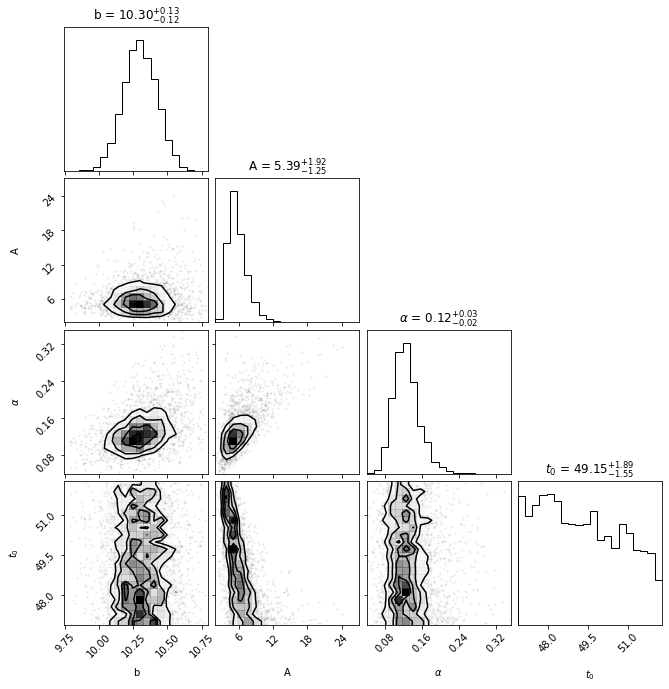

In [247]:
#CLD checking first model by comparing the corner plots of this parameter space with the plots of the above parameter
#CLD MCMC space
cornerplot(result1)

The above plots do look pretty similar, however the ultranest corner plots are a little tighter in parameter space.

In [243]:
result2 = sampler2.run()
sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, logz=-inf, remainder_fraction=100.0000%, Lmin=-96896.78, Lmax=-230.40


DEBUG:ultranest:iteration=40, ncalls=446, logz=-64226.74, remainder_fraction=100.0000%, Lmin=-64210.25, Lmax=-230.40


DEBUG:ultranest:iteration=80, ncalls=494, logz=-50909.39, remainder_fraction=100.0000%, Lmin=-50900.69, Lmax=-230.40


DEBUG:ultranest:iteration=90, ncalls=506, logz=-47376.90, remainder_fraction=100.0000%, Lmin=-47005.68, Lmax=-230.40


DEBUG:ultranest:iteration=120, ncalls=541, logz=-36773.87, remainder_fraction=100.0000%, Lmin=-36709.04, Lmax=-230.40


DEBUG:ultranest:iteration=160, ncalls=596, logz=-26457.49, remainder_fraction=100.0000%, Lmin=-26313.14, Lmax=-191.38


DEBUG:ultranest:iteration=180, ncalls=621, logz=-21723.89, remainder_fraction=100.0000%, Lmin=-21533.84, Lmax=-191.38


DEBUG:ultranest:iteration=200, ncalls=644, logz=-18896.03, remainder_fraction=100.0000%, Lmin=-18862.94, Lmax=-191.38


DEBUG:ultranest:iteration=240, ncalls=701, logz=-14966.79, remainder_fraction=100.0000%, Lmin=-14723.54, Lmax=-179.02


DEBUG:ultranest:iteration=270, ncalls=739, logz=-11675.12, remainder_fraction=100.0000%, Lmin=-11457.59, Lmax=-179.02


DEBUG:ultranest:iteration=280, ncalls=751, logz=-10859.85, remainder_fraction=100.0000%, Lmin=-10849.34, Lmax=-179.02


DEBUG:ultranest:iteration=320, ncalls=803, logz=-8425.99, remainder_fraction=100.0000%, Lmin=-8327.10, Lmax=-179.02


DEBUG:ultranest:iteration=360, ncalls=871, logz=-7005.91, remainder_fraction=100.0000%, Lmin=-6989.48, Lmax=-179.02


DEBUG:ultranest:iteration=400, ncalls=938, logz=-5576.69, remainder_fraction=100.0000%, Lmin=-5547.04, Lmax=-166.92


DEBUG:ultranest:iteration=440, ncalls=1005, logz=-4943.85, remainder_fraction=100.0000%, Lmin=-4907.37, Lmax=-166.92


DEBUG:ultranest:iteration=480, ncalls=1064, logz=-4247.03, remainder_fraction=100.0000%, Lmin=-4231.90, Lmax=-166.92


DEBUG:ultranest:iteration=520, ncalls=1128, logz=-3789.45, remainder_fraction=100.0000%, Lmin=-3775.87, Lmax=-166.92


DEBUG:ultranest:iteration=540, ncalls=1172, logz=-3616.91, remainder_fraction=100.0000%, Lmin=-3579.53, Lmax=-166.92


DEBUG:ultranest:iteration=560, ncalls=1203, logz=-3321.68, remainder_fraction=100.0000%, Lmin=-3309.77, Lmax=-166.92


DEBUG:ultranest:iteration=600, ncalls=1266, logz=-2870.46, remainder_fraction=100.0000%, Lmin=-2837.31, Lmax=-166.92


DEBUG:ultranest:iteration=640, ncalls=1333, logz=-2550.88, remainder_fraction=100.0000%, Lmin=-2541.87, Lmax=-166.92


DEBUG:ultranest:iteration=680, ncalls=1393, logz=-2345.49, remainder_fraction=100.0000%, Lmin=-2331.76, Lmax=-166.92


DEBUG:ultranest:iteration=720, ncalls=1471, logz=-2063.75, remainder_fraction=100.0000%, Lmin=-2051.98, Lmax=-166.92


DEBUG:ultranest:iteration=760, ncalls=1546, logz=-1803.21, remainder_fraction=100.0000%, Lmin=-1787.41, Lmax=-166.92


DEBUG:ultranest:iteration=800, ncalls=1626, logz=-1582.83, remainder_fraction=100.0000%, Lmin=-1571.86, Lmax=-166.92


DEBUG:ultranest:iteration=840, ncalls=1715, logz=-1384.91, remainder_fraction=100.0000%, Lmin=-1369.72, Lmax=-166.92


DEBUG:ultranest:iteration=880, ncalls=1831, logz=-1211.48, remainder_fraction=100.0000%, Lmin=-1203.06, Lmax=-166.92


DEBUG:ultranest:iteration=900, ncalls=1879, logz=-1141.58, remainder_fraction=100.0000%, Lmin=-1133.00, Lmax=-166.92


DEBUG:ultranest:iteration=920, ncalls=1926, logz=-1061.45, remainder_fraction=100.0000%, Lmin=-1052.34, Lmax=-166.92


DEBUG:ultranest:iteration=960, ncalls=2037, logz=-971.61, remainder_fraction=100.0000%, Lmin=-960.97, Lmax=-166.92


DEBUG:ultranest:iteration=990, ncalls=2098, logz=-894.48, remainder_fraction=100.0000%, Lmin=-883.55, Lmax=-166.92


DEBUG:ultranest:iteration=1000, ncalls=2130, logz=-870.02, remainder_fraction=100.0000%, Lmin=-859.97, Lmax=-166.92


DEBUG:ultranest:iteration=1040, ncalls=2217, logz=-799.16, remainder_fraction=100.0000%, Lmin=-788.08, Lmax=-166.92


DEBUG:ultranest:iteration=1080, ncalls=2329, logz=-730.36, remainder_fraction=100.0000%, Lmin=-721.79, Lmax=-166.92


DEBUG:ultranest:iteration=1120, ncalls=2432, logz=-649.61, remainder_fraction=100.0000%, Lmin=-640.73, Lmax=-166.92


DEBUG:ultranest:iteration=1160, ncalls=2537, logz=-590.70, remainder_fraction=100.0000%, Lmin=-580.01, Lmax=-166.92


DEBUG:ultranest:iteration=1170, ncalls=2558, logz=-575.84, remainder_fraction=100.0000%, Lmin=-567.10, Lmax=-166.92


DEBUG:ultranest:iteration=1200, ncalls=2653, logz=-544.59, remainder_fraction=100.0000%, Lmin=-536.07, Lmax=-166.92


DEBUG:ultranest:iteration=1240, ncalls=2778, logz=-500.93, remainder_fraction=100.0000%, Lmin=-489.82, Lmax=-166.92


DEBUG:ultranest:iteration=1260, ncalls=2830, logz=-467.91, remainder_fraction=100.0000%, Lmin=-459.25, Lmax=-166.92


DEBUG:ultranest:iteration=1280, ncalls=2876, logz=-443.46, remainder_fraction=100.0000%, Lmin=-434.07, Lmax=-166.92


DEBUG:ultranest:iteration=1320, ncalls=2993, logz=-407.36, remainder_fraction=100.0000%, Lmin=-397.99, Lmax=-166.92


DEBUG:ultranest:iteration=1350, ncalls=3094, logz=-387.39, remainder_fraction=100.0000%, Lmin=-378.40, Lmax=-165.85


DEBUG:ultranest:iteration=1360, ncalls=3124, logz=-382.57, remainder_fraction=100.0000%, Lmin=-373.57, Lmax=-165.85


DEBUG:ultranest:iteration=1400, ncalls=3240, logz=-365.37, remainder_fraction=100.0000%, Lmin=-355.65, Lmax=-156.30


DEBUG:ultranest:iteration=1440, ncalls=3345, logz=-340.80, remainder_fraction=100.0000%, Lmin=-330.47, Lmax=-156.30


DEBUG:ultranest:iteration=1480, ncalls=3486, logz=-317.68, remainder_fraction=100.0000%, Lmin=-308.78, Lmax=-156.30


DEBUG:ultranest:iteration=1520, ncalls=3633, logz=-299.96, remainder_fraction=100.0000%, Lmin=-290.64, Lmax=-156.30


DEBUG:ultranest:iteration=1556, ncalls=3773, logz=-289.07, remainder_fraction=100.0000%, Lmin=-280.49, Lmax=-156.30


DEBUG:ultranest:iteration=1560, ncalls=3788, logz=-288.00, remainder_fraction=100.0000%, Lmin=-279.22, Lmax=-156.30


DEBUG:ultranest:iteration=1600, ncalls=3963, logz=-276.19, remainder_fraction=100.0000%, Lmin=-267.51, Lmax=-156.30


DEBUG:ultranest:iteration=1638, ncalls=4096, logz=-266.64, remainder_fraction=100.0000%, Lmin=-257.86, Lmax=-156.30


DEBUG:ultranest:iteration=1640, ncalls=4102, logz=-266.14, remainder_fraction=100.0000%, Lmin=-257.33, Lmax=-156.30


DEBUG:ultranest:iteration=1680, ncalls=4274, logz=-257.27, remainder_fraction=100.0000%, Lmin=-248.55, Lmax=-156.30


DEBUG:ultranest:iteration=1710, ncalls=4392, logz=-249.09, remainder_fraction=100.0000%, Lmin=-239.69, Lmax=-156.30


DEBUG:ultranest:iteration=1720, ncalls=4437, logz=-246.64, remainder_fraction=100.0000%, Lmin=-238.01, Lmax=-156.30


DEBUG:ultranest:iteration=1749, ncalls=4581, logz=-241.74, remainder_fraction=100.0000%, Lmin=-233.55, Lmax=-156.30


DEBUG:ultranest:iteration=1760, ncalls=4628, logz=-239.82, remainder_fraction=100.0000%, Lmin=-230.40, Lmax=-156.30


DEBUG:ultranest:iteration=1785, ncalls=4767, logz=-234.29, remainder_fraction=100.0000%, Lmin=-225.78, Lmax=-156.30


DEBUG:ultranest:iteration=1800, ncalls=4878, logz=-231.76, remainder_fraction=100.0000%, Lmin=-223.22, Lmax=-156.30


DEBUG:ultranest:iteration=1835, ncalls=5082, logz=-227.70, remainder_fraction=100.0000%, Lmin=-218.65, Lmax=-151.61


DEBUG:ultranest:iteration=1840, ncalls=5121, logz=-226.76, remainder_fraction=100.0000%, Lmin=-217.84, Lmax=-151.61


DEBUG:ultranest:iteration=1873, ncalls=5303, logz=-221.56, remainder_fraction=100.0000%, Lmin=-212.89, Lmax=-151.61


DEBUG:ultranest:iteration=1880, ncalls=5341, logz=-220.69, remainder_fraction=100.0000%, Lmin=-212.15, Lmax=-151.61


DEBUG:ultranest:iteration=1900, ncalls=5467, logz=-218.27, remainder_fraction=100.0000%, Lmin=-209.84, Lmax=-151.61


DEBUG:ultranest:iteration=1920, ncalls=5596, logz=-216.55, remainder_fraction=100.0000%, Lmin=-208.23, Lmax=-151.61


DEBUG:ultranest:iteration=1942, ncalls=5762, logz=-214.99, remainder_fraction=100.0000%, Lmin=-206.87, Lmax=-151.61


DEBUG:ultranest:iteration=1960, ncalls=5884, logz=-213.71, remainder_fraction=100.0000%, Lmin=-205.35, Lmax=-151.61


DEBUG:ultranest:iteration=1980, ncalls=6009, logz=-212.32, remainder_fraction=100.0000%, Lmin=-203.77, Lmax=-151.05


DEBUG:ultranest:iteration=2000, ncalls=6149, logz=-210.51, remainder_fraction=100.0000%, Lmin=-201.97, Lmax=-151.05


DEBUG:ultranest:iteration=2034, ncalls=6376, logz=-208.10, remainder_fraction=100.0000%, Lmin=-199.83, Lmax=-151.05


DEBUG:ultranest:iteration=2040, ncalls=6430, logz=-207.71, remainder_fraction=100.0000%, Lmin=-199.25, Lmax=-151.05


DEBUG:ultranest:iteration=2065, ncalls=6665, logz=-205.64, remainder_fraction=100.0000%, Lmin=-197.05, Lmax=-151.05


DEBUG:ultranest:iteration=2080, ncalls=6789, logz=-204.66, remainder_fraction=100.0000%, Lmin=-196.34, Lmax=-151.05


DEBUG:ultranest:iteration=2111, ncalls=7045, logz=-202.92, remainder_fraction=100.0000%, Lmin=-194.60, Lmax=-151.05


DEBUG:ultranest:iteration=2120, ncalls=7121, logz=-202.40, remainder_fraction=100.0000%, Lmin=-193.94, Lmax=-151.05


DEBUG:ultranest:iteration=2139, ncalls=7346, logz=-201.28, remainder_fraction=100.0000%, Lmin=-192.76, Lmax=-151.05


DEBUG:ultranest:iteration=2156, ncalls=7575, logz=-200.40, remainder_fraction=100.0000%, Lmin=-192.14, Lmax=-151.05


DEBUG:ultranest:iteration=2160, ncalls=7599, logz=-200.24, remainder_fraction=100.0000%, Lmin=-192.05, Lmax=-151.05


DEBUG:ultranest:iteration=2183, ncalls=7838, logz=-199.25, remainder_fraction=100.0000%, Lmin=-190.91, Lmax=-151.05


DEBUG:ultranest:iteration=2200, ncalls=8023, logz=-198.52, remainder_fraction=100.0000%, Lmin=-190.26, Lmax=-151.05


DEBUG:ultranest:iteration=2232, ncalls=8244, logz=-197.25, remainder_fraction=100.0000%, Lmin=-188.88, Lmax=-151.05


DEBUG:ultranest:iteration=2240, ncalls=8310, logz=-196.95, remainder_fraction=100.0000%, Lmin=-188.70, Lmax=-151.05


DEBUG:ultranest:iteration=2250, ncalls=8387, logz=-196.58, remainder_fraction=100.0000%, Lmin=-188.21, Lmax=-151.05


DEBUG:ultranest:iteration=2280, ncalls=8627, logz=-195.51, remainder_fraction=100.0000%, Lmin=-187.19, Lmax=-151.05


DEBUG:ultranest:iteration=2313, ncalls=8860, logz=-194.49, remainder_fraction=100.0000%, Lmin=-186.18, Lmax=-151.05


DEBUG:ultranest:iteration=2320, ncalls=8933, logz=-194.27, remainder_fraction=100.0000%, Lmin=-185.99, Lmax=-151.05


DEBUG:ultranest:iteration=2340, ncalls=9150, logz=-193.74, remainder_fraction=100.0000%, Lmin=-185.50, Lmax=-151.05


DEBUG:ultranest:iteration=2360, ncalls=9266, logz=-193.18, remainder_fraction=100.0000%, Lmin=-184.99, Lmax=-151.05


DEBUG:ultranest:iteration=2386, ncalls=9501, logz=-192.59, remainder_fraction=100.0000%, Lmin=-184.47, Lmax=-151.05


DEBUG:ultranest:iteration=2400, ncalls=9611, logz=-192.29, remainder_fraction=100.0000%, Lmin=-184.09, Lmax=-151.05


DEBUG:ultranest:iteration=2427, ncalls=9866, logz=-191.68, remainder_fraction=100.0000%, Lmin=-183.42, Lmax=-151.05


DEBUG:ultranest:iteration=2430, ncalls=9878, logz=-191.61, remainder_fraction=100.0000%, Lmin=-183.38, Lmax=-151.05


DEBUG:ultranest:iteration=2440, ncalls=9932, logz=-191.41, remainder_fraction=100.0000%, Lmin=-183.18, Lmax=-151.05


DEBUG:ultranest:iteration=2469, ncalls=10177, logz=-190.85, remainder_fraction=100.0000%, Lmin=-182.71, Lmax=-151.05


DEBUG:ultranest:iteration=2480, ncalls=10368, logz=-190.66, remainder_fraction=100.0000%, Lmin=-182.49, Lmax=-151.05


DEBUG:ultranest:iteration=2493, ncalls=10603, logz=-190.43, remainder_fraction=100.0000%, Lmin=-182.16, Lmax=-151.05


DEBUG:ultranest:iteration=2517, ncalls=10828, logz=-190.01, remainder_fraction=100.0000%, Lmin=-181.83, Lmax=-151.05


DEBUG:ultranest:iteration=2520, ncalls=10846, logz=-189.96, remainder_fraction=100.0000%, Lmin=-181.79, Lmax=-151.05


DEBUG:ultranest:iteration=2537, ncalls=11068, logz=-189.70, remainder_fraction=100.0000%, Lmin=-181.61, Lmax=-151.05


DEBUG:ultranest:iteration=2558, ncalls=11317, logz=-189.42, remainder_fraction=100.0000%, Lmin=-181.42, Lmax=-151.05


DEBUG:ultranest:iteration=2560, ncalls=11324, logz=-189.40, remainder_fraction=100.0000%, Lmin=-181.41, Lmax=-151.05


DEBUG:ultranest:iteration=2581, ncalls=11589, logz=-189.16, remainder_fraction=100.0000%, Lmin=-181.19, Lmax=-151.05


DEBUG:ultranest:iteration=2598, ncalls=11803, logz=-188.97, remainder_fraction=100.0000%, Lmin=-181.05, Lmax=-151.05


DEBUG:ultranest:iteration=2600, ncalls=11825, logz=-188.95, remainder_fraction=100.0000%, Lmin=-181.05, Lmax=-151.05


DEBUG:ultranest:iteration=2610, ncalls=11983, logz=-188.85, remainder_fraction=100.0000%, Lmin=-180.96, Lmax=-151.05


DEBUG:ultranest:iteration=2629, ncalls=12229, logz=-188.66, remainder_fraction=100.0000%, Lmin=-180.72, Lmax=-151.05


DEBUG:ultranest:iteration=2640, ncalls=12412, logz=-188.55, remainder_fraction=100.0000%, Lmin=-180.58, Lmax=-151.05


DEBUG:ultranest:iteration=2659, ncalls=12633, logz=-188.37, remainder_fraction=100.0000%, Lmin=-180.40, Lmax=-151.05


DEBUG:ultranest:iteration=2672, ncalls=12875, logz=-188.25, remainder_fraction=100.0000%, Lmin=-180.31, Lmax=-151.05


DEBUG:ultranest:iteration=2680, ncalls=12944, logz=-188.18, remainder_fraction=100.0000%, Lmin=-180.25, Lmax=-151.05


DEBUG:ultranest:iteration=2690, ncalls=13188, logz=-188.10, remainder_fraction=100.0000%, Lmin=-180.17, Lmax=-151.05


DEBUG:ultranest:iteration=2700, ncalls=13353, logz=-188.02, remainder_fraction=100.0000%, Lmin=-180.09, Lmax=-151.05


DEBUG:ultranest:iteration=2715, ncalls=13623, logz=-187.90, remainder_fraction=100.0000%, Lmin=-180.02, Lmax=-151.05


DEBUG:ultranest:iteration=2720, ncalls=13703, logz=-187.86, remainder_fraction=100.0000%, Lmin=-179.98, Lmax=-151.05


DEBUG:ultranest:iteration=2738, ncalls=13980, logz=-187.73, remainder_fraction=100.0000%, Lmin=-179.85, Lmax=-151.05


DEBUG:ultranest:iteration=2749, ncalls=14225, logz=-187.66, remainder_fraction=100.0000%, Lmin=-179.80, Lmax=-151.05


DEBUG:ultranest:iteration=2757, ncalls=14462, logz=-187.61, remainder_fraction=100.0000%, Lmin=-179.75, Lmax=-151.05


DEBUG:ultranest:iteration=2760, ncalls=14495, logz=-187.59, remainder_fraction=100.0000%, Lmin=-179.74, Lmax=-151.05


DEBUG:ultranest:iteration=2774, ncalls=14715, logz=-187.50, remainder_fraction=100.0000%, Lmin=-179.65, Lmax=-151.05


DEBUG:ultranest:iteration=2790, ncalls=14889, logz=-187.40, remainder_fraction=100.0000%, Lmin=-179.59, Lmax=-151.05


DEBUG:ultranest:iteration=2800, ncalls=15088, logz=-187.35, remainder_fraction=100.0000%, Lmin=-179.55, Lmax=-151.05


DEBUG:ultranest:iteration=2818, ncalls=15357, logz=-187.25, remainder_fraction=100.0000%, Lmin=-179.48, Lmax=-151.05


DEBUG:ultranest:iteration=2827, ncalls=15592, logz=-187.21, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-151.05


DEBUG:ultranest:iteration=2840, ncalls=15790, logz=-187.14, remainder_fraction=100.0000%, Lmin=-179.43, Lmax=-151.05


DEBUG:ultranest:iteration=2851, ncalls=16053, logz=-187.09, remainder_fraction=100.0000%, Lmin=-179.41, Lmax=-151.05


DEBUG:ultranest:iteration=2861, ncalls=16283, logz=-187.05, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-151.05


DEBUG:ultranest:iteration=2870, ncalls=16602, logz=-187.01, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-151.05


DEBUG:ultranest:iteration=2878, ncalls=16848, logz=-186.98, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-151.05


DEBUG:ultranest:iteration=2880, ncalls=16916, logz=-186.97, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-151.05


DEBUG:ultranest:iteration=2892, ncalls=17160, logz=-186.93, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-151.05


DEBUG:ultranest:iteration=2906, ncalls=17429, logz=-186.88, remainder_fraction=100.0000%, Lmin=-179.25, Lmax=-151.05


DEBUG:ultranest:iteration=2917, ncalls=17670, logz=-186.84, remainder_fraction=100.0000%, Lmin=-179.23, Lmax=-151.05


DEBUG:ultranest:iteration=2920, ncalls=17709, logz=-186.83, remainder_fraction=100.0000%, Lmin=-179.23, Lmax=-151.05


DEBUG:ultranest:iteration=2934, ncalls=17931, logz=-186.78, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-151.05


DEBUG:ultranest:iteration=2941, ncalls=18163, logz=-186.76, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-151.05


DEBUG:ultranest:iteration=2950, ncalls=18410, logz=-186.73, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-149.93


DEBUG:ultranest:iteration=2958, ncalls=18635, logz=-186.71, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-149.93


DEBUG:ultranest:iteration=2960, ncalls=18678, logz=-186.70, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-149.93


DEBUG:ultranest:iteration=2968, ncalls=18910, logz=-186.68, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-149.93


DEBUG:ultranest:iteration=2975, ncalls=19081, logz=-186.66, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-149.93


DEBUG:ultranest:iteration=2987, ncalls=19347, logz=-186.63, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-149.93


DEBUG:ultranest:iteration=3000, ncalls=19565, logz=-186.59, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-149.93


DEBUG:ultranest:iteration=3010, ncalls=19814, logz=-186.57, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-149.93


DEBUG:ultranest:iteration=3024, ncalls=20062, logz=-186.53, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-149.93


DEBUG:ultranest:iteration=3033, ncalls=20324, logz=-186.51, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-149.93


DEBUG:ultranest:iteration=3040, ncalls=20525, logz=-186.50, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-149.93


DEBUG:ultranest:iteration=3047, ncalls=20806, logz=-186.48, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-149.93


DEBUG:ultranest:iteration=3055, ncalls=21072, logz=-186.47, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-149.93


DEBUG:ultranest:iteration=3062, ncalls=21274, logz=-186.45, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-145.84


DEBUG:ultranest:iteration=3070, ncalls=21564, logz=-186.44, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-145.84


DEBUG:ultranest:iteration=3078, ncalls=21818, logz=-186.42, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-145.84


DEBUG:ultranest:iteration=3080, ncalls=21868, logz=-186.42, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-145.84


DEBUG:ultranest:iteration=3086, ncalls=22185, logz=-186.41, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-145.84


DEBUG:ultranest:iteration=3092, ncalls=22424, logz=-186.39, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-145.84


DEBUG:ultranest:iteration=3100, ncalls=22706, logz=-186.38, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-145.84


DEBUG:ultranest:iteration=3109, ncalls=22976, logz=-186.37, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-145.84


DEBUG:ultranest:iteration=3118, ncalls=23241, logz=-186.35, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-145.84


DEBUG:ultranest:iteration=3120, ncalls=23258, logz=-186.35, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-145.84


DEBUG:ultranest:iteration=3122, ncalls=23547, logz=-186.34, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-145.84


DEBUG:ultranest:iteration=3131, ncalls=23826, logz=-186.33, remainder_fraction=100.0000%, Lmin=-178.88, Lmax=-145.84


DEBUG:ultranest:iteration=3142, ncalls=24059, logz=-186.31, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-145.84


DEBUG:ultranest:iteration=3146, ncalls=24406, logz=-186.30, remainder_fraction=100.0000%, Lmin=-178.81, Lmax=-145.84


DEBUG:ultranest:iteration=3150, ncalls=24613, logz=-186.30, remainder_fraction=100.0000%, Lmin=-178.79, Lmax=-145.84


DEBUG:ultranest:iteration=3155, ncalls=25001, logz=-186.29, remainder_fraction=100.0000%, Lmin=-178.76, Lmax=-145.84


DEBUG:ultranest:iteration=3160, ncalls=25177, logz=-186.28, remainder_fraction=100.0000%, Lmin=-178.71, Lmax=-145.84


DEBUG:ultranest:iteration=3168, ncalls=25540, logz=-186.26, remainder_fraction=100.0000%, Lmin=-178.65, Lmax=-145.84


DEBUG:ultranest:iteration=3174, ncalls=25886, logz=-186.25, remainder_fraction=100.0000%, Lmin=-178.59, Lmax=-145.84


DEBUG:ultranest:iteration=3179, ncalls=26152, logz=-186.24, remainder_fraction=100.0000%, Lmin=-178.55, Lmax=-145.84


DEBUG:ultranest:iteration=3183, ncalls=26452, logz=-186.23, remainder_fraction=100.0000%, Lmin=-178.51, Lmax=-145.84


DEBUG:ultranest:iteration=3187, ncalls=26733, logz=-186.23, remainder_fraction=100.0000%, Lmin=-178.48, Lmax=-145.84


DEBUG:ultranest:iteration=3197, ncalls=26998, logz=-186.21, remainder_fraction=100.0000%, Lmin=-178.37, Lmax=-145.84


DEBUG:ultranest:iteration=3200, ncalls=27109, logz=-186.20, remainder_fraction=100.0000%, Lmin=-178.35, Lmax=-145.84


DEBUG:ultranest:iteration=3204, ncalls=27329, logz=-186.19, remainder_fraction=100.0000%, Lmin=-178.31, Lmax=-145.84


DEBUG:ultranest:iteration=3208, ncalls=27602, logz=-186.18, remainder_fraction=100.0000%, Lmin=-178.25, Lmax=-145.84


DEBUG:ultranest:iteration=3214, ncalls=27997, logz=-186.17, remainder_fraction=100.0000%, Lmin=-178.16, Lmax=-145.84


DEBUG:ultranest:iteration=3223, ncalls=28268, logz=-186.15, remainder_fraction=100.0000%, Lmin=-178.07, Lmax=-145.84


DEBUG:ultranest:iteration=3229, ncalls=28513, logz=-186.13, remainder_fraction=100.0000%, Lmin=-177.97, Lmax=-145.84


DEBUG:ultranest:iteration=3236, ncalls=28765, logz=-186.11, remainder_fraction=100.0000%, Lmin=-177.82, Lmax=-145.84


DEBUG:ultranest:iteration=3240, ncalls=28856, logz=-186.10, remainder_fraction=100.0000%, Lmin=-177.77, Lmax=-145.84


DEBUG:ultranest:iteration=3257, ncalls=29169, logz=-186.04, remainder_fraction=100.0000%, Lmin=-177.48, Lmax=-145.84


DEBUG:ultranest:iteration=3276, ncalls=29427, logz=-185.96, remainder_fraction=100.0000%, Lmin=-177.08, Lmax=-145.84


DEBUG:ultranest:iteration=3280, ncalls=29455, logz=-185.94, remainder_fraction=100.0000%, Lmin=-177.06, Lmax=-145.84


DEBUG:ultranest:iteration=3291, ncalls=29686, logz=-185.88, remainder_fraction=100.0000%, Lmin=-176.79, Lmax=-145.84


DEBUG:ultranest:iteration=3307, ncalls=29924, logz=-185.77, remainder_fraction=100.0000%, Lmin=-176.43, Lmax=-145.84


DEBUG:ultranest:iteration=3320, ncalls=30092, logz=-185.68, remainder_fraction=100.0000%, Lmin=-176.27, Lmax=-145.84


DEBUG:ultranest:iteration=3332, ncalls=30228, logz=-185.58, remainder_fraction=100.0000%, Lmin=-176.01, Lmax=-145.84


DEBUG:ultranest:iteration=3344, ncalls=30493, logz=-185.47, remainder_fraction=100.0000%, Lmin=-175.74, Lmax=-145.84


DEBUG:ultranest:iteration=3360, ncalls=30748, logz=-185.31, remainder_fraction=100.0000%, Lmin=-175.58, Lmax=-145.84


DEBUG:ultranest:iteration=3372, ncalls=31003, logz=-185.19, remainder_fraction=100.0000%, Lmin=-175.32, Lmax=-145.84


DEBUG:ultranest:iteration=3384, ncalls=31266, logz=-185.07, remainder_fraction=100.0000%, Lmin=-175.16, Lmax=-145.84


DEBUG:ultranest:iteration=3396, ncalls=31485, logz=-184.94, remainder_fraction=100.0000%, Lmin=-174.92, Lmax=-145.84


DEBUG:ultranest:iteration=3400, ncalls=31614, logz=-184.89, remainder_fraction=100.0000%, Lmin=-174.80, Lmax=-145.84


DEBUG:ultranest:iteration=3411, ncalls=31856, logz=-184.75, remainder_fraction=100.0000%, Lmin=-174.53, Lmax=-145.84


DEBUG:ultranest:iteration=3420, ncalls=32023, logz=-184.63, remainder_fraction=100.0000%, Lmin=-174.39, Lmax=-145.84


DEBUG:ultranest:iteration=3437, ncalls=32280, logz=-184.39, remainder_fraction=100.0000%, Lmin=-173.95, Lmax=-145.84


DEBUG:ultranest:iteration=3440, ncalls=32444, logz=-184.34, remainder_fraction=100.0000%, Lmin=-173.90, Lmax=-145.84


DEBUG:ultranest:iteration=3458, ncalls=32739, logz=-184.07, remainder_fraction=100.0000%, Lmin=-173.61, Lmax=-145.84


DEBUG:ultranest:iteration=3472, ncalls=32981, logz=-183.85, remainder_fraction=100.0000%, Lmin=-173.34, Lmax=-145.84


DEBUG:ultranest:iteration=3477, ncalls=33223, logz=-183.77, remainder_fraction=100.0000%, Lmin=-173.15, Lmax=-145.84


DEBUG:ultranest:iteration=3480, ncalls=33307, logz=-183.71, remainder_fraction=100.0000%, Lmin=-173.05, Lmax=-145.84


DEBUG:ultranest:iteration=3492, ncalls=33577, logz=-183.50, remainder_fraction=100.0000%, Lmin=-172.80, Lmax=-145.84


DEBUG:ultranest:iteration=3502, ncalls=33842, logz=-183.32, remainder_fraction=100.0000%, Lmin=-172.61, Lmax=-145.84


DEBUG:ultranest:iteration=3509, ncalls=34123, logz=-183.20, remainder_fraction=100.0000%, Lmin=-172.50, Lmax=-145.84


DEBUG:ultranest:iteration=3518, ncalls=34321, logz=-183.04, remainder_fraction=100.0000%, Lmin=-172.33, Lmax=-145.84


DEBUG:ultranest:iteration=3520, ncalls=34410, logz=-183.01, remainder_fraction=100.0000%, Lmin=-172.30, Lmax=-145.84


DEBUG:ultranest:iteration=3529, ncalls=34771, logz=-182.86, remainder_fraction=100.0000%, Lmin=-172.12, Lmax=-145.84


DEBUG:ultranest:iteration=3539, ncalls=35075, logz=-182.69, remainder_fraction=100.0000%, Lmin=-171.90, Lmax=-145.84


DEBUG:ultranest:iteration=3548, ncalls=35326, logz=-182.54, remainder_fraction=100.0000%, Lmin=-171.80, Lmax=-145.84


DEBUG:ultranest:iteration=3560, ncalls=35579, logz=-182.35, remainder_fraction=100.0000%, Lmin=-171.58, Lmax=-145.84


DEBUG:ultranest:iteration=3572, ncalls=35816, logz=-182.15, remainder_fraction=100.0000%, Lmin=-171.37, Lmax=-145.84


DEBUG:ultranest:iteration=3581, ncalls=36128, logz=-182.01, remainder_fraction=100.0000%, Lmin=-171.21, Lmax=-145.84


DEBUG:ultranest:iteration=3588, ncalls=36399, logz=-181.89, remainder_fraction=100.0000%, Lmin=-170.99, Lmax=-145.84


DEBUG:ultranest:iteration=3599, ncalls=36640, logz=-181.71, remainder_fraction=100.0000%, Lmin=-170.73, Lmax=-145.84


DEBUG:ultranest:iteration=3600, ncalls=36641, logz=-181.69, remainder_fraction=100.0000%, Lmin=-170.73, Lmax=-145.84


DEBUG:ultranest:iteration=3612, ncalls=36910, logz=-181.48, remainder_fraction=100.0000%, Lmin=-170.47, Lmax=-145.84


DEBUG:ultranest:iteration=3623, ncalls=37203, logz=-181.28, remainder_fraction=100.0000%, Lmin=-170.31, Lmax=-145.84


DEBUG:ultranest:iteration=3634, ncalls=37443, logz=-181.09, remainder_fraction=100.0000%, Lmin=-170.07, Lmax=-145.84


DEBUG:ultranest:iteration=3640, ncalls=37597, logz=-180.99, remainder_fraction=100.0000%, Lmin=-169.97, Lmax=-145.84


DEBUG:ultranest:iteration=3652, ncalls=37848, logz=-180.78, remainder_fraction=100.0000%, Lmin=-169.70, Lmax=-145.84


DEBUG:ultranest:iteration=3661, ncalls=38123, logz=-180.62, remainder_fraction=100.0000%, Lmin=-169.53, Lmax=-145.84


DEBUG:ultranest:iteration=3667, ncalls=38350, logz=-180.52, remainder_fraction=100.0000%, Lmin=-169.39, Lmax=-145.84


DEBUG:ultranest:iteration=3676, ncalls=38612, logz=-180.36, remainder_fraction=100.0000%, Lmin=-169.28, Lmax=-145.84


DEBUG:ultranest:iteration=3680, ncalls=38744, logz=-180.30, remainder_fraction=100.0000%, Lmin=-169.21, Lmax=-145.84


DEBUG:ultranest:iteration=3690, ncalls=38937, logz=-180.13, remainder_fraction=100.0000%, Lmin=-168.99, Lmax=-145.84


DEBUG:ultranest:iteration=3701, ncalls=39210, logz=-179.95, remainder_fraction=100.0000%, Lmin=-168.82, Lmax=-145.84


DEBUG:ultranest:iteration=3710, ncalls=39473, logz=-179.80, remainder_fraction=100.0000%, Lmin=-168.65, Lmax=-145.84


DEBUG:ultranest:iteration=3720, ncalls=39704, logz=-179.64, remainder_fraction=100.0000%, Lmin=-168.47, Lmax=-145.84


DEBUG:ultranest:iteration=3731, ncalls=39951, logz=-179.46, remainder_fraction=100.0000%, Lmin=-168.20, Lmax=-145.84


DEBUG:ultranest:iteration=3740, ncalls=40191, logz=-179.31, remainder_fraction=100.0000%, Lmin=-168.05, Lmax=-145.84


DEBUG:ultranest:iteration=3747, ncalls=40424, logz=-179.19, remainder_fraction=100.0000%, Lmin=-167.89, Lmax=-145.84


DEBUG:ultranest:iteration=3758, ncalls=40651, logz=-179.01, remainder_fraction=100.0000%, Lmin=-167.64, Lmax=-145.84


DEBUG:ultranest:iteration=3760, ncalls=40705, logz=-178.97, remainder_fraction=100.0000%, Lmin=-167.60, Lmax=-145.84


DEBUG:ultranest:iteration=3767, ncalls=40955, logz=-178.85, remainder_fraction=100.0000%, Lmin=-167.49, Lmax=-145.84


DEBUG:ultranest:iteration=3778, ncalls=41210, logz=-178.66, remainder_fraction=100.0000%, Lmin=-167.34, Lmax=-145.84


DEBUG:ultranest:iteration=3783, ncalls=41361, logz=-178.58, remainder_fraction=100.0000%, Lmin=-167.30, Lmax=-145.84


DEBUG:ultranest:iteration=3795, ncalls=41593, logz=-178.39, remainder_fraction=100.0000%, Lmin=-167.06, Lmax=-145.84


DEBUG:ultranest:iteration=3800, ncalls=41695, logz=-178.31, remainder_fraction=100.0000%, Lmin=-166.97, Lmax=-145.84


DEBUG:ultranest:iteration=3812, ncalls=41973, logz=-178.13, remainder_fraction=100.0000%, Lmin=-166.85, Lmax=-145.84


DEBUG:ultranest:iteration=3821, ncalls=42232, logz=-178.01, remainder_fraction=100.0000%, Lmin=-166.77, Lmax=-145.84


DEBUG:ultranest:iteration=3832, ncalls=42451, logz=-177.86, remainder_fraction=100.0000%, Lmin=-166.55, Lmax=-145.84


DEBUG:ultranest:iteration=3838, ncalls=42682, logz=-177.78, remainder_fraction=100.0000%, Lmin=-166.45, Lmax=-145.84


DEBUG:ultranest:iteration=3840, ncalls=42797, logz=-177.75, remainder_fraction=100.0000%, Lmin=-166.40, Lmax=-145.84


DEBUG:ultranest:iteration=3852, ncalls=43044, logz=-177.57, remainder_fraction=100.0000%, Lmin=-166.08, Lmax=-145.84


DEBUG:ultranest:iteration=3862, ncalls=43274, logz=-177.42, remainder_fraction=100.0000%, Lmin=-165.97, Lmax=-145.84


DEBUG:ultranest:iteration=3870, ncalls=43459, logz=-177.30, remainder_fraction=100.0000%, Lmin=-165.86, Lmax=-145.84


DEBUG:ultranest:iteration=3878, ncalls=43610, logz=-177.18, remainder_fraction=100.0000%, Lmin=-165.66, Lmax=-145.84


DEBUG:ultranest:iteration=3880, ncalls=43626, logz=-177.15, remainder_fraction=100.0000%, Lmin=-165.63, Lmax=-145.84


DEBUG:ultranest:iteration=3892, ncalls=43781, logz=-176.96, remainder_fraction=100.0000%, Lmin=-165.35, Lmax=-145.84


DEBUG:ultranest:iteration=3898, ncalls=43936, logz=-176.87, remainder_fraction=100.0000%, Lmin=-165.29, Lmax=-145.84


DEBUG:ultranest:iteration=3907, ncalls=44087, logz=-176.73, remainder_fraction=100.0000%, Lmin=-165.16, Lmax=-145.84


DEBUG:ultranest:iteration=3918, ncalls=44231, logz=-176.56, remainder_fraction=100.0000%, Lmin=-164.98, Lmax=-145.84


DEBUG:ultranest:iteration=3920, ncalls=44309, logz=-176.53, remainder_fraction=100.0000%, Lmin=-164.97, Lmax=-145.84


DEBUG:ultranest:iteration=3929, ncalls=44444, logz=-176.40, remainder_fraction=100.0000%, Lmin=-164.83, Lmax=-145.84


DEBUG:ultranest:iteration=3943, ncalls=44606, logz=-176.17, remainder_fraction=100.0000%, Lmin=-164.32, Lmax=-145.84


DEBUG:ultranest:iteration=3953, ncalls=44772, logz=-176.00, remainder_fraction=100.0000%, Lmin=-164.18, Lmax=-145.84


DEBUG:ultranest:iteration=3960, ncalls=44830, logz=-175.88, remainder_fraction=100.0000%, Lmin=-163.99, Lmax=-145.84


DEBUG:ultranest:iteration=4000, ncalls=45004, logz=-175.20, remainder_fraction=100.0000%, Lmin=-163.26, Lmax=-145.81


DEBUG:ultranest:iteration=4040, ncalls=45152, logz=-174.45, remainder_fraction=100.0000%, Lmin=-162.37, Lmax=-145.81


DEBUG:ultranest:iteration=4050, ncalls=45200, logz=-174.26, remainder_fraction=100.0000%, Lmin=-162.09, Lmax=-145.81


DEBUG:ultranest:iteration=4080, ncalls=45308, logz=-173.67, remainder_fraction=99.9999%, Lmin=-161.41, Lmax=-145.81


DEBUG:ultranest:iteration=4120, ncalls=45438, logz=-172.94, remainder_fraction=99.9998%, Lmin=-160.76, Lmax=-145.81


DEBUG:ultranest:iteration=4140, ncalls=45510, logz=-172.63, remainder_fraction=99.9998%, Lmin=-160.50, Lmax=-145.81


DEBUG:ultranest:iteration=4160, ncalls=45554, logz=-172.34, remainder_fraction=99.9997%, Lmin=-160.17, Lmax=-145.81


DEBUG:ultranest:iteration=4200, ncalls=45659, logz=-171.69, remainder_fraction=99.9994%, Lmin=-159.16, Lmax=-145.19


DEBUG:ultranest:iteration=4230, ncalls=45734, logz=-171.17, remainder_fraction=99.9990%, Lmin=-158.77, Lmax=-145.19


DEBUG:ultranest:iteration=4240, ncalls=45752, logz=-171.02, remainder_fraction=99.9988%, Lmin=-158.64, Lmax=-145.19


DEBUG:ultranest:iteration=4280, ncalls=45875, logz=-170.43, remainder_fraction=99.9980%, Lmin=-157.99, Lmax=-145.19


DEBUG:ultranest:iteration=4320, ncalls=45990, logz=-169.81, remainder_fraction=99.9960%, Lmin=-157.15, Lmax=-145.19


DEBUG:ultranest:iteration=4360, ncalls=46086, logz=-169.16, remainder_fraction=99.9930%, Lmin=-156.38, Lmax=-145.19


DEBUG:ultranest:iteration=4400, ncalls=46211, logz=-168.52, remainder_fraction=99.9869%, Lmin=-155.76, Lmax=-145.19


DEBUG:ultranest:iteration=4436, ncalls=46361, logz=-168.05, remainder_fraction=99.9791%, Lmin=-155.38, Lmax=-145.19


DEBUG:ultranest:iteration=4440, ncalls=46368, logz=-168.00, remainder_fraction=99.9779%, Lmin=-155.32, Lmax=-145.19


DEBUG:ultranest:iteration=4480, ncalls=46522, logz=-167.52, remainder_fraction=99.9646%, Lmin=-154.80, Lmax=-145.19


DEBUG:ultranest:iteration=4500, ncalls=46577, logz=-167.30, remainder_fraction=99.9566%, Lmin=-154.61, Lmax=-145.19


DEBUG:ultranest:iteration=4520, ncalls=46628, logz=-167.10, remainder_fraction=99.9455%, Lmin=-154.34, Lmax=-145.19


DEBUG:ultranest:iteration=4560, ncalls=46780, logz=-166.66, remainder_fraction=99.9097%, Lmin=-153.86, Lmax=-145.19


DEBUG:ultranest:iteration=4590, ncalls=46876, logz=-166.36, remainder_fraction=99.8731%, Lmin=-153.55, Lmax=-145.19


DEBUG:ultranest:iteration=4600, ncalls=46892, logz=-166.27, remainder_fraction=99.8577%, Lmin=-153.43, Lmax=-145.19


DEBUG:ultranest:iteration=4640, ncalls=46993, logz=-165.88, remainder_fraction=99.7892%, Lmin=-152.90, Lmax=-145.19


DEBUG:ultranest:iteration=4680, ncalls=47081, logz=-165.52, remainder_fraction=99.6805%, Lmin=-152.61, Lmax=-145.19


DEBUG:ultranest:iteration=4720, ncalls=47165, logz=-165.19, remainder_fraction=99.5547%, Lmin=-152.18, Lmax=-145.19


DEBUG:ultranest:iteration=4760, ncalls=47274, logz=-164.88, remainder_fraction=99.3629%, Lmin=-151.88, Lmax=-145.19


DEBUG:ultranest:iteration=4770, ncalls=47298, logz=-164.80, remainder_fraction=99.3714%, Lmin=-151.78, Lmax=-144.38


DEBUG:ultranest:iteration=4800, ncalls=47368, logz=-164.59, remainder_fraction=99.2019%, Lmin=-151.51, Lmax=-144.38


DEBUG:ultranest:iteration=4840, ncalls=47468, logz=-164.31, remainder_fraction=98.9798%, Lmin=-151.19, Lmax=-144.38


DEBUG:ultranest:iteration=4860, ncalls=47521, logz=-164.17, remainder_fraction=98.8110%, Lmin=-151.02, Lmax=-144.38


DEBUG:ultranest:iteration=4880, ncalls=47571, logz=-164.03, remainder_fraction=98.6269%, Lmin=-150.84, Lmax=-144.38


DEBUG:ultranest:iteration=4920, ncalls=47658, logz=-163.78, remainder_fraction=98.2218%, Lmin=-150.56, Lmax=-144.38


DEBUG:ultranest:iteration=4960, ncalls=47781, logz=-163.53, remainder_fraction=97.7683%, Lmin=-150.23, Lmax=-144.38


DEBUG:ultranest:iteration=5000, ncalls=47872, logz=-163.30, remainder_fraction=97.2725%, Lmin=-149.93, Lmax=-144.38


DEBUG:ultranest:iteration=5040, ncalls=48000, logz=-163.06, remainder_fraction=96.6561%, Lmin=-149.62, Lmax=-144.38


DEBUG:ultranest:iteration=5080, ncalls=48103, logz=-162.85, remainder_fraction=95.7920%, Lmin=-149.42, Lmax=-144.38


DEBUG:ultranest:iteration=5120, ncalls=48207, logz=-162.65, remainder_fraction=95.1749%, Lmin=-149.20, Lmax=-144.38


DEBUG:ultranest:iteration=5130, ncalls=48227, logz=-162.60, remainder_fraction=94.8626%, Lmin=-149.15, Lmax=-144.38


DEBUG:ultranest:iteration=5160, ncalls=48308, logz=-162.46, remainder_fraction=94.0795%, Lmin=-148.88, Lmax=-144.38


DEBUG:ultranest:iteration=5200, ncalls=48417, logz=-162.27, remainder_fraction=92.9524%, Lmin=-148.71, Lmax=-144.38


DEBUG:ultranest:iteration=5220, ncalls=48483, logz=-162.19, remainder_fraction=92.2592%, Lmin=-148.64, Lmax=-144.38


DEBUG:ultranest:iteration=5240, ncalls=48514, logz=-162.11, remainder_fraction=91.8232%, Lmin=-148.57, Lmax=-144.38


DEBUG:ultranest:iteration=5280, ncalls=48587, logz=-161.95, remainder_fraction=90.4140%, Lmin=-148.32, Lmax=-144.38


DEBUG:ultranest:iteration=5310, ncalls=48642, logz=-161.84, remainder_fraction=89.2043%, Lmin=-148.18, Lmax=-144.38


DEBUG:ultranest:iteration=5320, ncalls=48662, logz=-161.80, remainder_fraction=88.8342%, Lmin=-148.12, Lmax=-144.38


DEBUG:ultranest:iteration=5360, ncalls=48740, logz=-161.66, remainder_fraction=87.0820%, Lmin=-147.96, Lmax=-144.38


DEBUG:ultranest:iteration=5400, ncalls=48847, logz=-161.53, remainder_fraction=85.5488%, Lmin=-147.77, Lmax=-144.38


DEBUG:ultranest:iteration=5440, ncalls=48946, logz=-161.41, remainder_fraction=83.6249%, Lmin=-147.60, Lmax=-144.38


DEBUG:ultranest:iteration=5480, ncalls=49033, logz=-161.28, remainder_fraction=81.8630%, Lmin=-147.42, Lmax=-144.38


DEBUG:ultranest:iteration=5520, ncalls=49131, logz=-161.17, remainder_fraction=79.7089%, Lmin=-147.28, Lmax=-144.38


DEBUG:ultranest:iteration=5560, ncalls=49245, logz=-161.06, remainder_fraction=77.0762%, Lmin=-147.13, Lmax=-144.38


DEBUG:ultranest:iteration=5580, ncalls=49298, logz=-161.01, remainder_fraction=75.6520%, Lmin=-147.07, Lmax=-144.38


DEBUG:ultranest:iteration=5600, ncalls=49332, logz=-160.97, remainder_fraction=74.2532%, Lmin=-147.01, Lmax=-144.38


DEBUG:ultranest:iteration=5640, ncalls=49413, logz=-160.87, remainder_fraction=71.5072%, Lmin=-146.88, Lmax=-144.38


DEBUG:ultranest:iteration=5680, ncalls=49504, logz=-160.79, remainder_fraction=69.5894%, Lmin=-146.76, Lmax=-144.38


DEBUG:ultranest:iteration=5720, ncalls=49583, logz=-160.71, remainder_fraction=67.3827%, Lmin=-146.66, Lmax=-144.38


DEBUG:ultranest:iteration=5760, ncalls=49694, logz=-160.63, remainder_fraction=64.8143%, Lmin=-146.54, Lmax=-144.38


DEBUG:ultranest:iteration=5800, ncalls=49753, logz=-160.56, remainder_fraction=62.0271%, Lmin=-146.41, Lmax=-144.38


DEBUG:ultranest:iteration=5840, ncalls=49820, logz=-160.49, remainder_fraction=59.3362%, Lmin=-146.33, Lmax=-144.38


DEBUG:ultranest:iteration=5850, ncalls=49843, logz=-160.47, remainder_fraction=58.7182%, Lmin=-146.29, Lmax=-144.38


DEBUG:ultranest:iteration=5880, ncalls=49894, logz=-160.43, remainder_fraction=56.4891%, Lmin=-146.21, Lmax=-144.38


DEBUG:ultranest:iteration=5920, ncalls=49965, logz=-160.37, remainder_fraction=53.6756%, Lmin=-146.14, Lmax=-144.36


DEBUG:ultranest:iteration=5960, ncalls=50055, logz=-160.31, remainder_fraction=50.9974%, Lmin=-146.05, Lmax=-144.36


DEBUG:ultranest:iteration=6000, ncalls=50134, logz=-160.26, remainder_fraction=48.3278%, Lmin=-145.95, Lmax=-144.36


DEBUG:ultranest:iteration=6030, ncalls=50189, logz=-160.23, remainder_fraction=46.7133%, Lmin=-145.90, Lmax=-144.35


DEBUG:ultranest:iteration=6040, ncalls=50207, logz=-160.21, remainder_fraction=45.9175%, Lmin=-145.87, Lmax=-144.35


DEBUG:ultranest:iteration=6080, ncalls=50280, logz=-160.17, remainder_fraction=43.4799%, Lmin=-145.80, Lmax=-144.35


DEBUG:ultranest:iteration=6120, ncalls=50346, logz=-160.13, remainder_fraction=41.0336%, Lmin=-145.74, Lmax=-144.35


DEBUG:ultranest:iteration=6160, ncalls=50410, logz=-160.09, remainder_fraction=38.6780%, Lmin=-145.66, Lmax=-144.35


DEBUG:ultranest:iteration=6200, ncalls=50510, logz=-160.05, remainder_fraction=36.4084%, Lmin=-145.60, Lmax=-144.35


DEBUG:ultranest:iteration=6210, ncalls=50530, logz=-160.04, remainder_fraction=35.7846%, Lmin=-145.59, Lmax=-144.35


DEBUG:ultranest:iteration=6240, ncalls=50587, logz=-160.02, remainder_fraction=34.2106%, Lmin=-145.55, Lmax=-144.35


DEBUG:ultranest:iteration=6280, ncalls=50655, logz=-159.99, remainder_fraction=32.1083%, Lmin=-145.50, Lmax=-144.35


DEBUG:ultranest:iteration=6320, ncalls=50720, logz=-159.96, remainder_fraction=29.9604%, Lmin=-145.45, Lmax=-144.35


DEBUG:ultranest:iteration=6360, ncalls=50785, logz=-159.93, remainder_fraction=28.0879%, Lmin=-145.40, Lmax=-144.30


DEBUG:ultranest:iteration=6400, ncalls=50857, logz=-159.91, remainder_fraction=26.1417%, Lmin=-145.34, Lmax=-144.30


DEBUG:ultranest:iteration=6440, ncalls=50930, logz=-159.89, remainder_fraction=24.4168%, Lmin=-145.29, Lmax=-144.30


DEBUG:ultranest:iteration=6480, ncalls=51007, logz=-159.86, remainder_fraction=22.6718%, Lmin=-145.24, Lmax=-144.30


DEBUG:ultranest:iteration=6520, ncalls=51077, logz=-159.84, remainder_fraction=21.0709%, Lmin=-145.19, Lmax=-144.30


DEBUG:ultranest:iteration=6560, ncalls=51152, logz=-159.83, remainder_fraction=19.6711%, Lmin=-145.14, Lmax=-144.30


DEBUG:ultranest:iteration=6570, ncalls=51170, logz=-159.82, remainder_fraction=19.3795%, Lmin=-145.13, Lmax=-144.30


DEBUG:ultranest:iteration=6600, ncalls=51223, logz=-159.81, remainder_fraction=18.2857%, Lmin=-145.10, Lmax=-144.30


DEBUG:ultranest:iteration=6640, ncalls=51310, logz=-159.79, remainder_fraction=16.9313%, Lmin=-145.06, Lmax=-144.30


DEBUG:ultranest:iteration=6660, ncalls=51352, logz=-159.78, remainder_fraction=16.2880%, Lmin=-145.04, Lmax=-144.30


DEBUG:ultranest:iteration=6680, ncalls=51398, logz=-159.78, remainder_fraction=15.6457%, Lmin=-145.03, Lmax=-144.30


DEBUG:ultranest:iteration=6720, ncalls=51478, logz=-159.76, remainder_fraction=14.4883%, Lmin=-145.00, Lmax=-144.30


DEBUG:ultranest:iteration=6750, ncalls=51537, logz=-159.75, remainder_fraction=13.6339%, Lmin=-144.97, Lmax=-144.30


DEBUG:ultranest:iteration=6760, ncalls=51555, logz=-159.75, remainder_fraction=13.4081%, Lmin=-144.96, Lmax=-144.30


DEBUG:ultranest:iteration=6800, ncalls=51644, logz=-159.74, remainder_fraction=12.4058%, Lmin=-144.92, Lmax=-144.30


DEBUG:ultranest:iteration=6840, ncalls=51735, logz=-159.73, remainder_fraction=11.4280%, Lmin=-144.89, Lmax=-144.30


DEBUG:ultranest:iteration=6880, ncalls=51812, logz=-159.72, remainder_fraction=10.5104%, Lmin=-144.85, Lmax=-144.30


DEBUG:ultranest:iteration=6920, ncalls=51887, logz=-159.71, remainder_fraction=9.6890%, Lmin=-144.82, Lmax=-144.30


DEBUG:ultranest:iteration=6930, ncalls=51901, logz=-159.71, remainder_fraction=9.4855%, Lmin=-144.82, Lmax=-144.30


DEBUG:ultranest:iteration=6960, ncalls=51957, logz=-159.70, remainder_fraction=8.9127%, Lmin=-144.80, Lmax=-144.30


DEBUG:ultranest:iteration=7000, ncalls=52019, logz=-159.69, remainder_fraction=8.1837%, Lmin=-144.78, Lmax=-144.30


DEBUG:ultranest:iteration=7020, ncalls=52055, logz=-159.69, remainder_fraction=7.8396%, Lmin=-144.77, Lmax=-144.30


DEBUG:ultranest:iteration=7040, ncalls=52086, logz=-159.69, remainder_fraction=7.5119%, Lmin=-144.75, Lmax=-144.30


DEBUG:ultranest:iteration=7080, ncalls=52151, logz=-159.68, remainder_fraction=6.8843%, Lmin=-144.73, Lmax=-144.30


DEBUG:ultranest:iteration=7110, ncalls=52209, logz=-159.67, remainder_fraction=6.4497%, Lmin=-144.71, Lmax=-144.30


DEBUG:ultranest:iteration=7120, ncalls=52224, logz=-159.67, remainder_fraction=6.3220%, Lmin=-144.71, Lmax=-144.30


DEBUG:ultranest:iteration=7160, ncalls=52293, logz=-159.67, remainder_fraction=5.8043%, Lmin=-144.69, Lmax=-144.30


DEBUG:ultranest:iteration=7200, ncalls=52351, logz=-159.66, remainder_fraction=5.3125%, Lmin=-144.67, Lmax=-144.30


DEBUG:ultranest:iteration=7240, ncalls=52413, logz=-159.66, remainder_fraction=4.8609%, Lmin=-144.65, Lmax=-144.30


DEBUG:ultranest:iteration=7280, ncalls=52479, logz=-159.65, remainder_fraction=4.4420%, Lmin=-144.63, Lmax=-144.30


DEBUG:ultranest:iteration=7320, ncalls=52548, logz=-159.65, remainder_fraction=4.0706%, Lmin=-144.62, Lmax=-144.30


DEBUG:ultranest:iteration=7360, ncalls=52626, logz=-159.64, remainder_fraction=3.7219%, Lmin=-144.60, Lmax=-144.30


DEBUG:ultranest:iteration=7380, ncalls=52669, logz=-159.64, remainder_fraction=3.5547%, Lmin=-144.60, Lmax=-144.30


DEBUG:ultranest:iteration=7400, ncalls=52704, logz=-159.64, remainder_fraction=3.3959%, Lmin=-144.59, Lmax=-144.30


DEBUG:ultranest:iteration=7440, ncalls=52764, logz=-159.64, remainder_fraction=3.0985%, Lmin=-144.58, Lmax=-144.30


DEBUG:ultranest:iteration=7470, ncalls=52814, logz=-159.64, remainder_fraction=2.8910%, Lmin=-144.57, Lmax=-144.30


DEBUG:ultranest:iteration=7480, ncalls=52828, logz=-159.64, remainder_fraction=2.8256%, Lmin=-144.57, Lmax=-144.30


DEBUG:ultranest:iteration=7520, ncalls=52891, logz=-159.63, remainder_fraction=2.5828%, Lmin=-144.56, Lmax=-144.30


DEBUG:ultranest:iteration=7560, ncalls=52967, logz=-159.63, remainder_fraction=2.3577%, Lmin=-144.54, Lmax=-144.30


DEBUG:ultranest:iteration=7600, ncalls=53045, logz=-159.63, remainder_fraction=2.1510%, Lmin=-144.53, Lmax=-144.30


DEBUG:ultranest:iteration=7640, ncalls=53114, logz=-159.63, remainder_fraction=1.9618%, Lmin=-144.52, Lmax=-144.30


DEBUG:ultranest:iteration=7650, ncalls=53138, logz=-159.63, remainder_fraction=1.9166%, Lmin=-144.52, Lmax=-144.30


DEBUG:ultranest:iteration=7680, ncalls=53189, logz=-159.63, remainder_fraction=1.7876%, Lmin=-144.51, Lmax=-144.30


DEBUG:ultranest:iteration=7720, ncalls=53266, logz=-159.62, remainder_fraction=1.6271%, Lmin=-144.50, Lmax=-144.30


DEBUG:ultranest:iteration=7740, ncalls=53301, logz=-159.62, remainder_fraction=1.5527%, Lmin=-144.49, Lmax=-144.30


DEBUG:ultranest:iteration=7760, ncalls=53334, logz=-159.62, remainder_fraction=1.4826%, Lmin=-144.49, Lmax=-144.30


DEBUG:ultranest:iteration=7800, ncalls=53402, logz=-159.62, remainder_fraction=1.3495%, Lmin=-144.48, Lmax=-144.30


DEBUG:ultranest:iteration=7840, ncalls=53464, logz=-159.62, remainder_fraction=1.2289%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7880, ncalls=53525, logz=-159.62, remainder_fraction=1.1177%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=7920, ncalls=53601, logz=-159.62, remainder_fraction=1.0168%, Lmin=-144.45, Lmax=-144.30


[ultranest] Explored until L=-1e+02  


INFO:ultranest:Explored until L=-1e+02  


[ultranest] Likelihood function evaluations: 53611


INFO:ultranest:Likelihood function evaluations: 53611
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -159.6 +- 0.1054


INFO:ultranest:  logZ = -159.6 +- 0.1054


[ultranest] Effective samples strategy satisfied (ESS = 2157.2, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2157.2, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)


[ultranest]   logZ error budget: single: 0.18 bs:0.11 tail:0.01 total:0.11 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.18 bs:0.11 tail:0.01 total:0.11 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -159.607 +- 0.213
  single instance: logZ = -159.607 +- 0.182
  bootstrapped   : logZ = -159.610 +- 0.213
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 164.0 iterations

    b                   10.32 +- 0.12
    A                   2.78 +- 0.39
    $t_0$               55.4 +- 1.0
    $\sigma$            5.26 +- 0.83


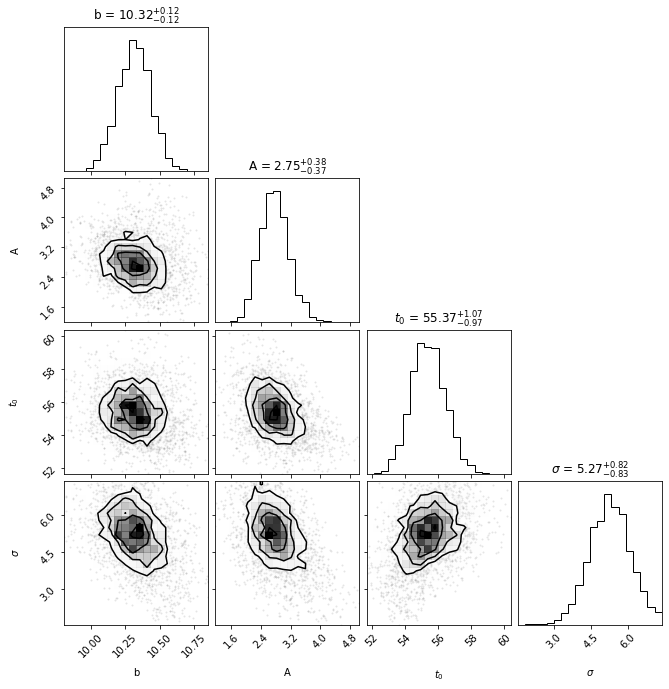

In [244]:
#CLD sort of just interested in seeing this but also i think would give a good visualization if something was totally
#CLD off the mark
cornerplot(result2)

In [272]:
#CLD from the model comparison documentation provided by ultranest 
#CLD at https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html
#CLD the bayes factor is calculated by taking the exp of the difference of logz 
bayes_factor = np.exp(result2['logz'] - result1['logz'])
ln_b = np.log(bayes_factor)
print("Bayes factor = %.2f" % bayes_factor)
print('Ln(B) = %.2f')

Bayes factor = -4.26


From this Bayes factor, the burst model of this flux is favored over the Gaussian profile model, but the two models are essentially favored the same.

SRT: I think your printed out statement is wrong or from a previous cell execution. You get the points because this is about the correct difference in log evidences between the models, but the Bayes factor is the exponential of this -4.26 value. Your first statement about the burst model being favored is correct. I don't understand what the second statement means: "the two models are essentially favored the same"?